In [0]:
!nvidia-smi

Mon Jun 10 08:21:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import files
uploaded = files.upload()

Saving sparse_eq.png to sparse_eq.png


In [0]:
uploaded = files.upload()

Saving Figure 15-5. A single graph to train a stacked autoencoder.jpg to Figure 15-5. A single graph to train a stacked autoencoder.jpg
Saving Figure 15-8. Unsupervised pretraining using autoencoders.jpg to Figure 15-8. Unsupervised pretraining using autoencoders.jpg
Saving Figure 15-9. Denoising autoencoders, with Gaussian noise (left) or dropout (right).jpg to Figure 15-9. Denoising autoencoders, with Gaussian noise (left) or dropout (right).jpg
Saving Figure 15-10. Sparsity loss.png to Figure 15-10. Sparsity loss.png
Saving Figure 15-12. Images of handwritten digits generated by the variational autoencoder.png to Figure 15-12. Images of handwritten digits generated by the variational autoencoder.png
Saving Figure15-3.png to Figure15-3.png
Saving Figure15-4.png to Figure15-4.png
Saving Figure15-5.png to Figure15-5.png
Saving Figure15-8.png to Figure15-8.png
Saving Figure15-9.png to Figure15-9.png
Saving gan.PNG to gan.PNG
Saving gan_eq.PNG to gan_eq.PNG
Saving generated_digits_plot.p

In [0]:
uploaded = files.upload()

NameError: ignored

In [0]:
!ls

 15-11.png
'15-11 Variational autoencoder (left), and an instance going through it (right).png'
 ae_1.png
 ae_2.png
 checkpoint
 cross_kl.png
 cross.png
 distribution.PNG
 entropy_eq.png
 entropy_ex.png
 extracted_features_plot.png
'Figure 15-10. Sparsity loss.png'
'Figure 15-12. Images of handwritten digits generated by the variational autoencoder.png'
'Figure 15-1. The chess memory experiment (left) and a simple autoencoder (right).jpg'
'Figure 15-2. PCA performed by an undercomplete linear autoencoder.jpg'
 Figure15-3.png
'Figure 15-3. Stacked autoencoder.jpg'
 Figure15-4.png
'Figure 15-4. Training one autoencoder at a time.jpg'
'Figure 15-5. A single graph to train a stacked autoencoder.jpg'
 Figure15-5.png
 Figure15-8.png
'Figure 15-8. Unsupervised pretraining using autoencoders.jpg'
'Figure 15-9. Denoising autoencoders, with Gaussian noise (left) or dropout (right).jpg'
 Figure15-9.png
 gan_eq.PNG
 gan_generated_image_epoch_100.png
 gan_generated_image_epoch_1.png
 gan_generated_

In [0]:
uploaded = files.upload()

Saving gan.PNG to gan (1).PNG
Saving gan_eq.PNG to gan_eq (1).PNG
Saving police.PNG to police (2).PNG


In [0]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [0]:
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # 최소값을 0으로 만들어 패딩이 하얗게 보이도록 합니다.
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

In [0]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os
import sys
import tensorflow as tf
# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

**15장 – 오토인코더**

In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [0]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
#         X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

In [0]:
from IPython.display import Image

# 15.6 희소 오토인코더

출처 - 기계학습(오일석 지음, 한빛 아카데미)

## 희소코딩

- Sparse Coding은 unsupervised learning 방법으로, overcomplete 기저벡터를 기반으로 데이터를 좀 더 효율적으로 표현하기 위한 용도로 개발
- 푸리에 변환, 웨이블릿 변환의 경우 기저함수(기저벡터)의 선형 결합으로 신호를 표현.

사전 $D$를 구성하는 기저 벡터의 선형 결합으로 신호(영상) $x$를 표현


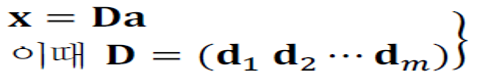

In [0]:
Image('sparseCoding_eq.png')

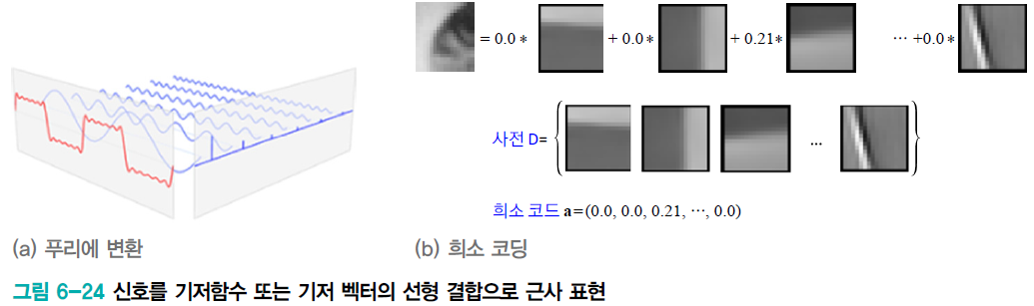

In [0]:
Image('sparseCoding.png')



- (a)에서 빨간색은 입력으로 주어진 파형, 파란색은 기저함수, 6개의 수직 막대는 선형 결합의 계수

희소 코딩이 다른 변환 기법과 다른 점
 - 푸리에 변환은 삼각함수를 이용하여 사전(기저 벡터)를 알아내는데, 비지도 학습으로 사전(기저 벡터)를 자동으로 알아냄.
 - 사전의 크기를 과잉 환벽하게 책정
 - 희소 코드를 구성하는 요소 대부분이 0값을 가짐.

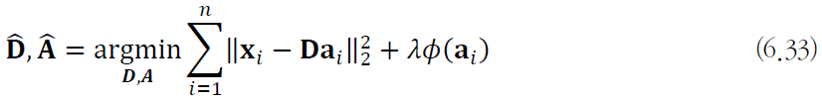

In [0]:
Image('spCoding_eq.png')



- 오른쪽 변의 첫 번째 항은 희소 코드로 근사표현되는 값 Da가 주어진 신호 x와 가까워야 한다는 것을 말함.
- 두 번쨰 항은 희소 코드가 희소해야한다는 조건으로 일종의 규제 항이다. (람다 기호는 어느 항을 더 중시할지 결정하는 가중치.)

## 희소 오토인코더

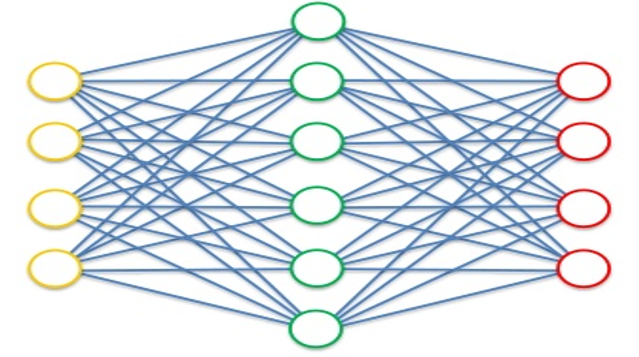

In [0]:
Image('ae_1.png')

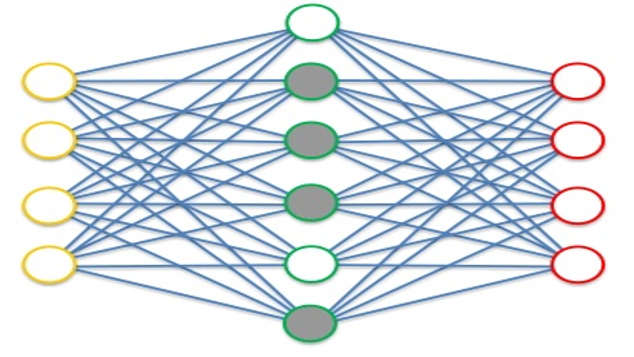

In [0]:
Image('ae_2.png')

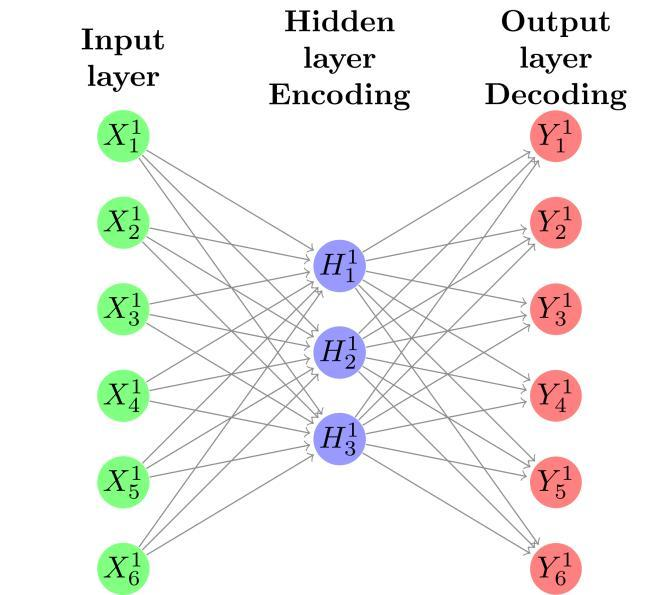

In [0]:
Image('SparseAE_Structure.png')

#### 오토인코더는 어떤 감독 없이도 입력 데이터의 효율적인 표현인 **코딩**을 학습할 수 있는 인공 신경망. 

데이터에서 일정한 구조 또는 숨어있는 패턴을 찾아 효율적으로 데이터를 표현할 수 있어야 함. 

 여러 기법 중 좋은 특성을 추출하도록 만드는 제약의 방식으로 **희소(sparsity) 인코더**가 있다.

- 히든 유닛의 개수가 입력보다 크면 위의 그림과 같이 sparsity 제약을 가하면 된다.


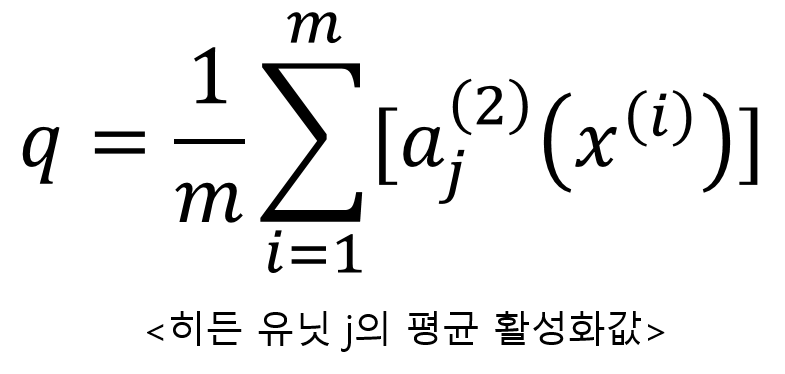

In [0]:
Image('sparse_eq.png')


- 비용 함수에 적절한 항을 추가하여 오토인코더가 코딩층에서 활성화되는 뉴런 수를 감소시키도록 만듬.
 - 예를 들어 코딩층에서 평균적으로 5% 뉴런만 두드러지게 활성화되도록 강제함. $p$=0.05
   
=> 이렇게 하면 적은 수의 활성화된 뉴런을 조합하여 입력을 표현해야 함. 결국 코딩층의 각 뉴런은 유용한 특성을 표현하게 됩니다.
 - 희소 모델을 만들기 위해 먼저 각 훈련 반복에서 코딩층의 실제 희소 정도를 측정. 
 - 이를 위해 전체 훈련 배치에 대해 코딩층의 평균적인 활성화를 계산.(단, 배치 크기는 너무 작지 않아야 한다. 그렇지 않으면 평균값이 정확하지 않을 것.)
 
 
 

- 각 뉴런에 대한 평균 활성화 정도를 알면 비용 함수에 **희소 손실**(sparsity loss)을 추가하여 뉴런이 너무 활성화되지 않도록 규제할 수 있음.
 예를 들어 한 뉴런의 평균 활성화가 0.3이고 목표 희소 정도가 0.1이라면, 이 뉴런은 덜 활성화되도록 규제되어야 합니다.
 간단한 방법은 제곱 오차를 추가하는 것.실전에서 더 좋은 방법은 평균 제곱 오차보다 훨씬 강한 그래디언트를 가진 **쿨백 라이블러 발산을 사용**하는 것.
  - **목표는 히든 레이어의 활성함수의 결과값을 대부분 inactive하게 만들어야 함.**
 - 활성화 함수로로 시그모이드 함수를 사용하면 값이 (0, 1) 범위 사이로 나오므로 최대한 0(inactive)에 가까이 나오도록 함. 만약 활성화 함수로 tanh를 사용한다면 활성함수의 결과값은 (-1, 1) 범위에서 나오는데 최대한 -1(inactive)에 근접하게 출력하게 만들어야 함.
 
 두 개의 이산 확률 분포 $P$와 $Q$가 주어졌을 떄, 이 두 분산 사이의  $D_{\mathrm{KL}}(P\|Q)$는 아래의 식 15-1을 사용해 계산할 수 있음.

### KL-Divergence

**식 15-1: 쿨백 라이블러 발산**

$
D_{\mathrm{KL}}(P\|Q) = \sum\limits_{i} P(i) \log \dfrac{P(i)}{Q(i)}
$


- 식 15-1에서 코딩층을 뉴런이 활성화될 목표 확률 $p$ 와 실제 확률 $q$ 사이의 발산을 측정. 이산 확률 분포 KL 발산은 아래와 같이 간단해짐.
- KL 다이번전스는 두 확률분포가 얼마나 다른지 측정. 또는 두 확률분포 사이의 엔트로피 or 발산을 측정.
- 예를 들어, $P$와 $Q$가 같을 때 0이 된다는 사실 => 서로 유사하다, 거리 개념 내포.
- 목표 확률 $p$와 실제 확률 $q$가 다를 수록 값이 커짐.

**식 15-2: 목표 희소 정도 $p$ 와 실제 희소 정도 $q$ 사이의 KL 발산**

$
D_{\mathrm{KL}}(p\|q) = p \, \log \dfrac{p}{q} + (1-p) \log \dfrac{1-p}{1-q}
$

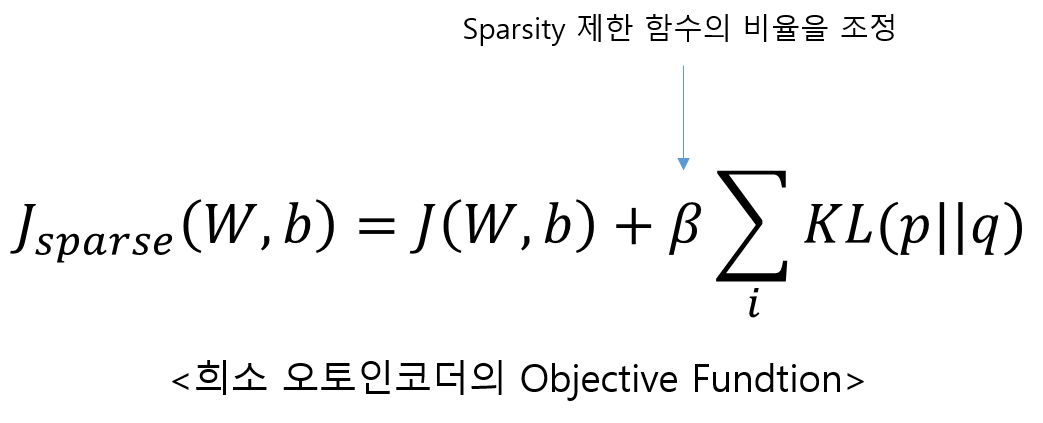

In [0]:
Image('sparse_obj.png')

- 코딩층의 각 뉴런에 대해 희소 손실을 계산했다면, 이 손실들을 모두 합해서 비용 함수의 결과에 더한다.
- 희소 손실과 재구성 손실의 상대적 중요성을 제어하기 위해 희소 손실에 희소 가중치 하이퍼파라미터를 곱한다.
- 가중치가 너무 크면 모델이 목표 희소에 가깝게 되겠지만 입력을 적절히 재구성하지 못해서 쓸모없는 모델이 될 수 있음.
- 반대로 가중치가 너무 작으면 모델이 희소를 거의 무시할 것이므로 어떤 흥미로운 특성도 학습하지 못할 것.


0이 아닌 요소를 희소하게 가지도록 하는 구현 방법은 여러가지가 존재..
- 예로) 히든 레이어의 큰 순서로 $N$개만 남기고 나머지를 0으로 바꾸는 방법이 있음

### 자기정보

정보이론에서 메시지의 정보량을 확률로 측정한다.

 - 확률이 낮은 사건일수록 더 많은 정보를 전달한다.
   - "고비 사막에 눈이 왔다." => 사람들이 이 소식에 주목한다.
   - "대관령에 눈이 왔다." => 사람들이 특별히 반응을 보이지 않는다.
 - 어떤 사건이 일어날 확률을 추정할 수 있다면 그 사건에 대한 정보량을 측정할 수 있다.
 

**정보량(자기정보, self-information)**

확률변수 $x$에 대해서


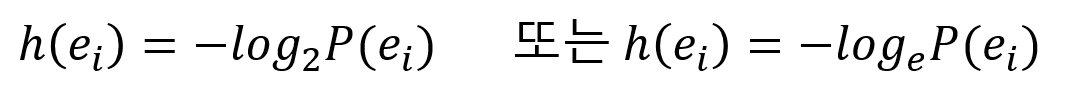

In [0]:
Image('information_eq.png')


- $e$는 확률변수 $x$의 정의역.
- 밑이 2인 로그함수의 경우 자기 정보의 단위는 비트. 확률이 1/2일 때 1비트의 정보량을 가짐. 밑이 e인 자연로그를 사용하는 경우 확률이 1/e일 떄 1만큼의 정보량을 가진다.(단위는 나츠)

### 엔트로피

- 자기 정보가 특정 사건의 정보량을 측정한다.
- 반면에 엔트로피는 확률 분포의 무질서도(불확실성)을 측정



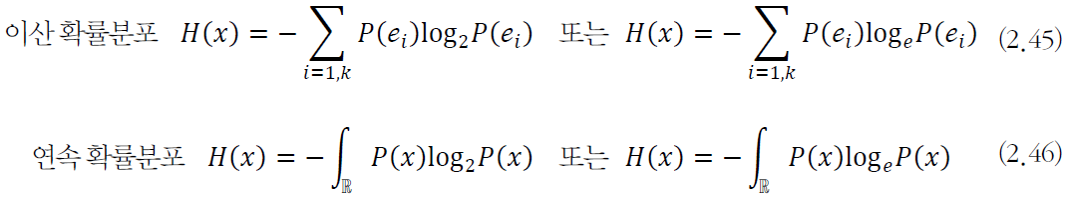

In [0]:
Image('entropy_eq.png')

#### 엔트로피 예

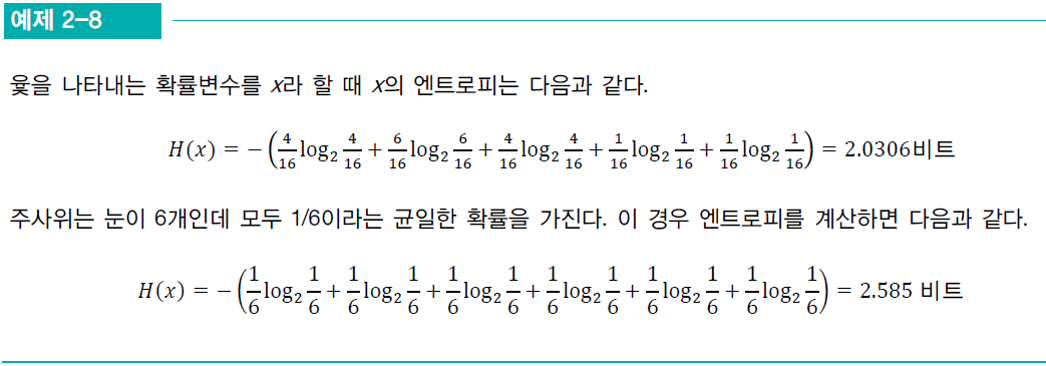

In [0]:
Image('entropy_ex.png')



- 주사위는 모든 사건이 동일한 확률을 가진다. 어떤 사건이 일어날지 윷보다 예측하기 어려움.
=> 주사위는 윷보다 무질서하고 불확실성이 더 큼
=> 엔트로피가 더 높음

- 정의역의 크기와 엔트로피는 비례 관계

#### 교차 엔트로피와 KL 다이버전스

- 앞의 엔트로피는 한 확률분포의 무질서 정도를 측정.

- 두 확률분포 간의 엔트로피를 측정하는 것을 교차 엔트로피(cross entropy)라고 함. 단, 두 확률분포는 같은 확률변수에 대해 정의되어 있어야 함.


두 확률분포 P와 Q 사이의 교차 엔트로피


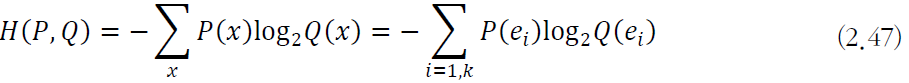

In [0]:
Image('cross.png')

## KL 다이버전스 유도

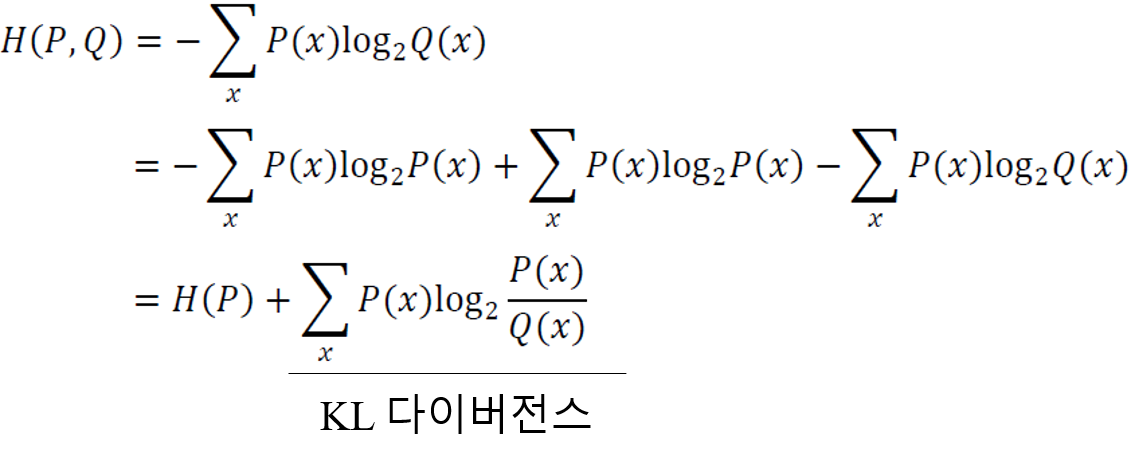

In [0]:
Image('cross_kl.png')

#### KL 다이버전스
- 두 확률분포 사이에 얼마나 다른지 측정할 떄 주로 사용



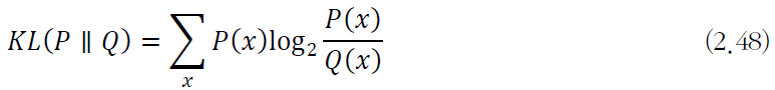

In [0]:
Image('kl.png')

#### 교차 엔트로피와 KL 다이버전스의 관계

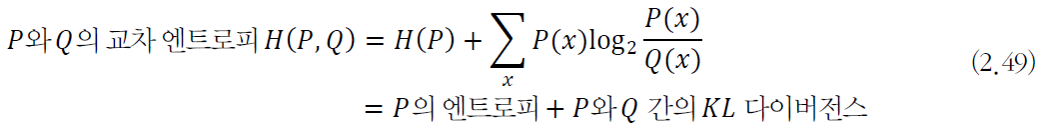

In [0]:
Image('relation.png')

- 거리 개념을 내포한다고 해석할 수 있음.

### 쿨백 라이블러 발산(KL-Divergence), MSE의 Loss 비교 

[0, 1, 0, 0.95]

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


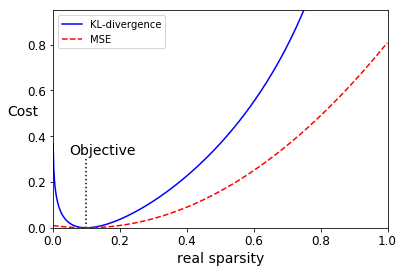

In [0]:
from matplotlib import font_manager, rc
#font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
#rc('font', family=font_name)

p = 0.1
q = np.linspace(0.001, 0.999, 500) # 0.001과 0.999 사이의 랜덤값을 500개 갖는 array
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:") # p가 중앙선, y축은 0~0.0 범위
plt.text(0.05, 0.32, "Objective", fontsize=14) 
plt.plot(q, kl_div, "b-", label="KL-divergence") # 500개 array를 입력으로 그에 따른 kl-div 값을 y값으로 취급, 그래프로 출력
plt.plot(q, mse, "r--", label="MSE") # 500개 array를 입력으로 그에 따른 mse 값을 y값으로 취급, 그래프로 출력,
plt.legend(loc="upper left")
plt.xlabel("real sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95]) # x는 [0, 1], y는 [0, 0.95] 사이 범위로 그래프 설정.
#save_fig("sparsity_loss_plot")

## 15.6.1 희소 오토인코더 구현

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # 희소 코딩 유닛
n_outputs = n_inputs

### 평균 제곱 오차 사용 시

In [0]:
def kl_divergence(p, q):
    # 쿨백 라이블러 발산
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) 
outputs = tf.layers.dense(hidden1, n_outputs)                     

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # 배치 평균
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
import time

In [0]:
n_epochs = 100
batch_size = 1000

start = time.time()
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")
print("time :", time.time() - start)

0 Train MSE: 0.13764465 	Sparsity loss: 0.90867686 	Total loss: 0.31938004
1 Train MSE: 0.059780527 	Sparsity loss: 0.02385321 	Total loss: 0.06455117
2 Train MSE: 0.05259748 	Sparsity loss: 0.02887623 	Total loss: 0.05837273
3 Train MSE: 0.050172243 	Sparsity loss: 0.19674301 	Total loss: 0.08952084
4 Train MSE: 0.04457513 	Sparsity loss: 0.0070949756 	Total loss: 0.045994125
5 Train MSE: 0.03982869 	Sparsity loss: 0.35642117 	Total loss: 0.11111292
6 Train MSE: 0.03850078 	Sparsity loss: 0.048918962 	Total loss: 0.04828457
7 Train MSE: 0.03621183 	Sparsity loss: 0.023476766 	Total loss: 0.04090718
8 Train MSE: 0.033634793 	Sparsity loss: 0.057289448 	Total loss: 0.045092683
9 Train MSE: 0.030880697 	Sparsity loss: 0.042790554 	Total loss: 0.039438806
10 Train MSE: 0.028282981 	Sparsity loss: 0.32261726 	Total loss: 0.09280643
11 Train MSE: 0.025015583 	Sparsity loss: 0.030907825 	Total loss: 0.03119715
12 Train MSE: 0.023248762 	Sparsity loss: 0.08871906 	Total loss: 0.040992573
13 T

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_sparse.ckpt


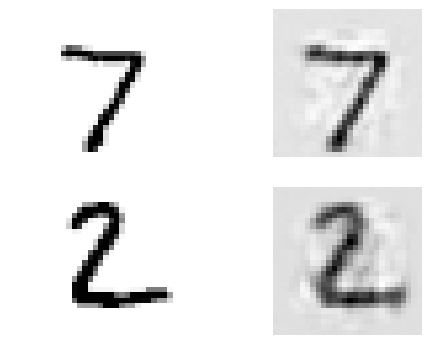

In [0]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt") 

=================================================

### 교차 엔트로피 사용


코딩층은 0에서 1사이의 값을 출력해야 하므로 시그모이드 활성화 함수를 사용합니다:

In [0]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)

훈련 속도를 높일 수 있는 한 가지 기교는 MSE 대신 더 큰 그래디언트를 가지는 재구성 손실을 사용하는 것.
보통 크로스 엔트로피가 좋은 선택.
이를 위해
입력을 0과 1사이로 정규화하고 로지스틱 활성화 함수를 사용하고 나서, 크로스엔트로피를 사용합니다:

In [0]:
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits) # logits의 의미 : 입력 데이터를 모델로 전방향 진행하여 나온 결과물
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy) # Computes the mean of elements across dimensions of a tensor.

=================================================================================================

In [0]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # 희소 코딩 유닛
n_outputs = n_inputs

In [0]:
def kl_divergence(p, q):
    # 쿨백 라이블러 발산
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) 
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)
# outputs = tf.layers.dense(hidden1, n_outputs)      



hidden1_mean = tf.reduce_mean(hidden1, axis=0) # 배치 평균
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
#reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
n_epochs = 100
batch_size = 1000

start = time.time()
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")
print("time :", time.time() - start)

0 Train MSE: 135619.55 	Sparsity loss: 291.66095 	Total loss: 135677.88
1 Train MSE: 96593.695 	Sparsity loss: 287.55627 	Total loss: 96651.2
2 Train MSE: 76200.64 	Sparsity loss: 297.12433 	Total loss: 76260.06
3 Train MSE: 67032.05 	Sparsity loss: 300.6568 	Total loss: 67092.18
4 Train MSE: 61547.273 	Sparsity loss: 303.17807 	Total loss: 61607.91
5 Train MSE: 57634.83 	Sparsity loss: 304.16333 	Total loss: 57695.66
6 Train MSE: 57064.855 	Sparsity loss: 310.46478 	Total loss: 57126.95
7 Train MSE: 55744.87 	Sparsity loss: 297.44574 	Total loss: 55804.36
8 Train MSE: 54868.51 	Sparsity loss: 300.05945 	Total loss: 54928.523
9 Train MSE: 54237.793 	Sparsity loss: 298.79987 	Total loss: 54297.555
10 Train MSE: 53307.023 	Sparsity loss: 308.2294 	Total loss: 53368.668
11 Train MSE: 54078.55 	Sparsity loss: 299.86093 	Total loss: 54138.523
12 Train MSE: 53196.64 	Sparsity loss: 298.27496 	Total loss: 53256.297
13 Train MSE: 52739.71 	Sparsity loss: 294.00388 	Total loss: 52798.51
14 Trai

# 15.7 변이형 오토인코더 (Variational Autoencoder)

### concept

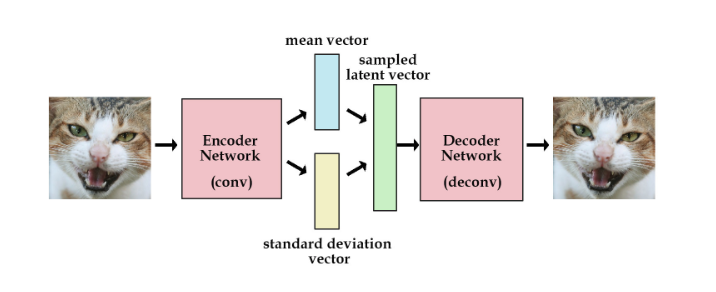

In [0]:
Image('vae_concept.PNG')

사람은 고양이 사진들이 저마다 다르게 생겼어도 고양이라는 것을 인식.

=> 고양이의 추상화된 특징(털 색깔, 눈 모양, 이빨 개수 등)을 보고 고양이라는 결론을 냄.
=> 변이형 오토인코더는 위와 같은 추상화된 특징인 잠재 변수(latent variable) $z$를 만들어내 입력 $x$를 복원한다.

concept 출처 - https://ratsgo.github.io/generative%20model/2018/01/27/VAE/

- 2014년에 다이데릭 킹마와 맥스 웰링에 의해 소개.

특징
 - 확률형 오토 인코더(probabilistic autoencoder). 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정됨.(잡음제거 오토인코더는 훈련 시에만 무작위성을 사용.)
 - 생성 오토인코더(generative autoencoder)
 
=> 두 가지 속성이 RBM과 유사하게 만든다. 훈련이 더 쉽고 샘플링 과정이 훨씬 빠름.(RBM에서는 샐로운 샘플을 만들기 전에 네트워크가 '열평형' 상태로 안정될 떄까지 기다려야 함.)
- 주어진 코딩을 바로 만드는 대신, 인코더는 평균 코딩과 표준편차를 만든다.
- 실제 코딩은 평균이 뮤이고, 표준편차가 시그마인 가우시안 분포에서 랜덤하게 샘플링됨.
- 그 후 디코더가 샘플링된 코딩을 보통처럼 디코딩.
- 먼저 인코더가 뮤와 시그마를 만들면 코딩이 랜덤하게 선택(뮤의 위치와 정확히 같지 않음.)
- 마지막으로 이 코딩이 디코드되고 최종 출력은 훈련 샘플을 닮게 됨.

훈련하는 동안 비용함수가 코딩을 가우시안 샘플들의 군집처럼 보이는 거의 (초)구 형태를 가진 코딩 공간(잠재 변수 공간)으로 점진적으로 이동시킴. 그러므로 훈련이 끝난 뒤 새로운 샘플을 매우 쉽게 생성할 수 있게 됨.



비용함수
- 두 부분으로 구성
- 첫 번쨰) 오토인코더가 입력을 재생산하도록 만드는 일반적인 재구성 손실
- 두 번째) 간단한 가우시안 분포에서 샘플된 것 같은 코딩을 가지도록 오토인코더를 강제하는 잠재 변수 손실. 여기에 목표 분포(가우시안 분포)와 실제 코딩 분포 사이의 KL 발산을 사용

잠재 변수 $z$는 무수히 많은 경우가 존재하여 변분추론(Variational Inference)이라는 계산이 어려운 확률분포를 
다루기 쉬운 분포로 근사하는 방법을 이용.
 - 기존 : $p(z)$, 근사 : $q(z)$

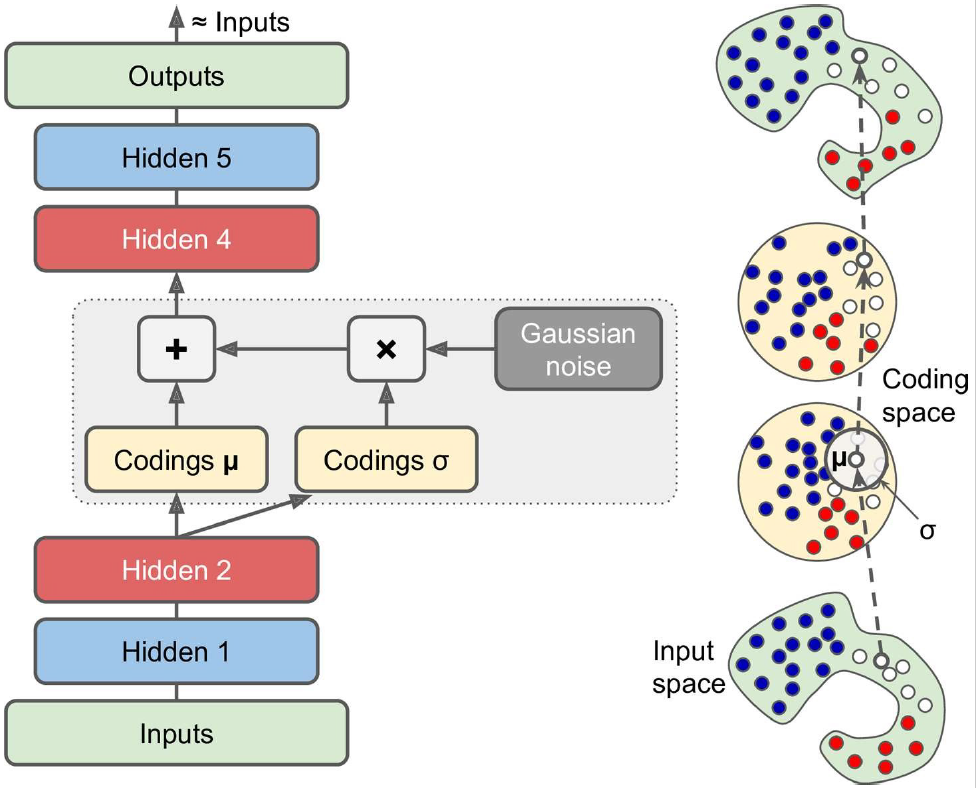

In [0]:
Image('15-11.png')

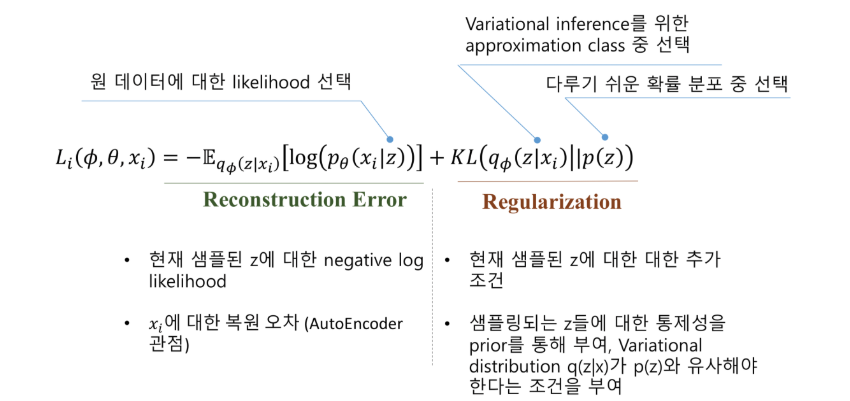

In [0]:
Image('vae_eq.PNG')

In [0]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # 코딩 유닛
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

latent_loss에서

자주 사용하는 변형은 $\sigma$ 가 아니라 $\gamma = \log\left(\sigma^2\right)$ 을 출력하도록 인코더를 훈련시키는 것입니다. $\sigma$ 는 $ \sigma = \exp\left(\dfrac{\gamma}{2}\right) $ 로 쉽게 계산할 수 있습니다.

- 표준편차는 양수여야 하지만 은닉층의 출력값은 음수이 수 있으므로 로그 스케일로 변경하여 학습합니다.

In [0]:
eps = 1e-10 # NaN을 반환하는 log(0)을 피하기 위한 안전항
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [0]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")

0 Train total loss: 29572.203 	Reconstruction loss: 23151.008 	Latent loss: 6421.1963
1 Train total loss: 28620.953 	Reconstruction loss: 21450.049 	Latent loss: 7170.904
2 Train total loss: 27015.365 	Reconstruction loss: 22027.074 	Latent loss: 4988.2905
3 Train total loss: 27767.275 	Reconstruction loss: 22226.871 	Latent loss: 5540.405
4 Train total loss: 28869.762 	Reconstruction loss: 20700.754 	Latent loss: 8169.0073
5 Train total loss: 25203.68 	Reconstruction loss: 19641.434 	Latent loss: 5562.2456
6 Train total loss: 26776.473 	Reconstruction loss: 21528.006 	Latent loss: 5248.467
7 Train total loss: 21943.28 	Reconstruction loss: 17829.645 	Latent loss: 4113.6353
8 Train total loss: 23020.701 	Reconstruction loss: 19437.668 	Latent loss: 3583.0332
9 Train total loss: 28440.938 	Reconstruction loss: 21704.73 	Latent loss: 6736.206
10 Train total loss: 26110.426 	Reconstruction loss: 20252.621 	Latent loss: 5857.8057
11 Train total loss: 25925.035 	Reconstruction loss: 19735.3

## 제한된 볼츠만 머신(RBM)

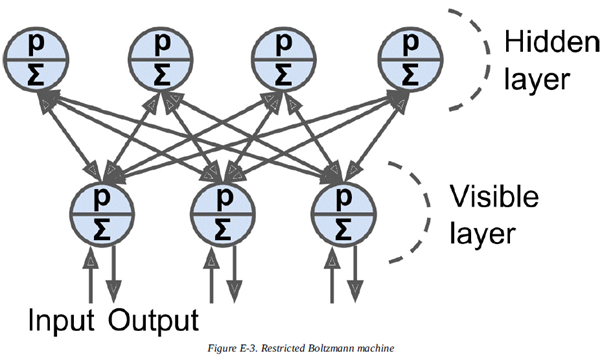

In [0]:
Image('rbm.png')

- 가시 유닛과 히든 유닛 사이에만 연결이 있고 가시 유닛들 사이와 은닉 유닛들 사이에는 어떤 연결도 없는 볼츠만 머신
- 기존 볼츠만 머신은 오래 실행하면 원래 설정이 잊혀지는 열평형 상태에 도달. 열평형 상태에 도달하면 적절하게 네트워크의 파라미터를 지정하고 상태를 관찰함으로써 다양한 종류의 확률 분포를 시뮬레이션할 수 있음.(생성 모델)
- RBM은 열평형에 도달할 떄까지 기다릴 필요가 없음. 정방향, 역방향, 그리고 다시 정방향으로 계산이 진행되는 것이 전부.

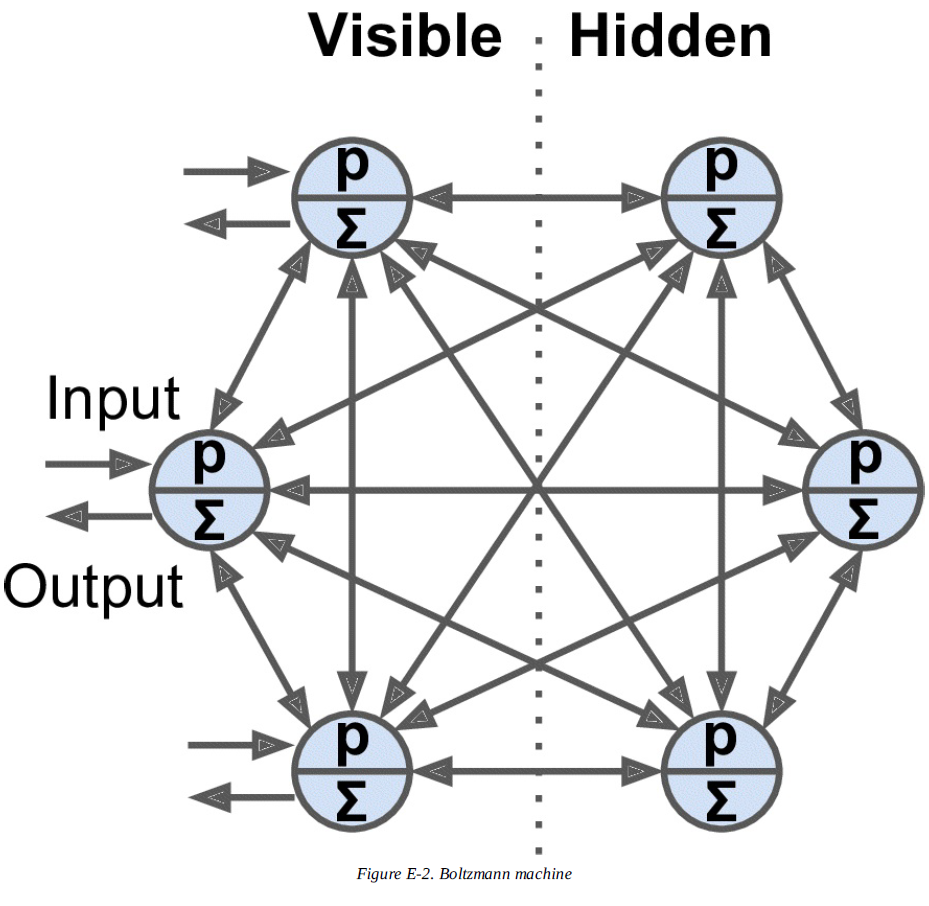

In [0]:
Image('bm.png')

## 15.7.1 숫자 이미지 생성

변이형 오토인코더 모델을 훈련시켜, 가우시안 분포에서 랜덤한 코딩을 샘플링하고 나서 이미지를 생성

In [0]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                         
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt")  
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 32289.992 	Reconstruction loss: 25590.861 	Latent loss: 6699.13
1 Train total loss: 28199.309 	Reconstruction loss: 22141.533 	Latent loss: 6057.7764
2 Train total loss: 27895.44 	Reconstruction loss: 21641.785 	Latent loss: 6253.6543
3 Train total loss: 28308.658 	Reconstruction loss: 21736.45 	Latent loss: 6572.209
4 Train total loss: 23832.156 	Reconstruction loss: 19610.201 	Latent loss: 4221.955
5 Train total loss: 21277.266 	Reconstruction loss: 17100.809 	Latent loss: 4176.456
6 Train total loss: 21817.67 	Reconstruction loss: 17989.746 	Latent loss: 3827.9246
7 Train total loss: 22456.105 	Reconstruction loss: 17205.367 	Latent loss: 5250.738
8 Train total loss: 21742.525 	Reconstruction loss: 17666.35 	Latent loss: 4076.176
9 Train total loss: 28972.26 	Reconstruction loss: 20899.95 	Latent loss: 8072.31
10 Train total loss: 26447.56 	Reconstruction loss: 19662.61 	Latent loss: 6784.9517
11 Train total loss: 26740.46 	Reconstruction loss: 20659.9 	Latent lo

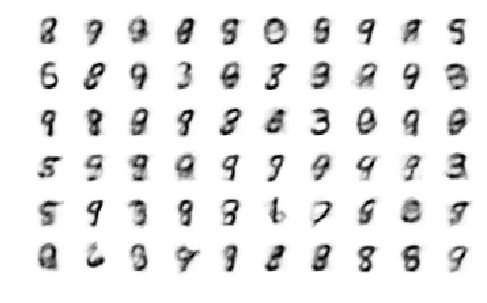

In [0]:
plt.figure(figsize=(8,50)) 
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

**[VAE의 장단점]**

장점
- GAN에 비해 학습이 안정적. loss 함수에서 reconstruction error와 같이 평가 기준이 명확하기 때문.
- 데이터에 내재한 latent variable z도 함께 학습 할 수 있음(feature learning)
- q(z|x)f를 추론.

단점
- GAN에 비해 샘플이 선명하지 않고 저퀄리티.

======================================================================

## 15.8 다른 오토인코더들

- 수축 오토인코더(CAE, Conatractive autoencoder)
  - 훈련하는 동안 입력에 대한 코딩의 변화율이 작도록 제약을 받습니다. 다시 말해 두 개의 비슷한 입력은 비슷한 코딩이 되어야 합니다.

  - 잡음제거 오토인코더(DAE, Denoising autoencoder)와 CAE의 공통점은 입력이 조금 변하더라도 '은닉층'의 출력, 즉 추출된 측징 벡터는 가급적 상수로 유지한다는 것. 차이점은 상수를 유지하는 전략에 있다. DAE는 일부러 잡음을 추가한 후 잡음이 없는 원래 패턴을 찾는 방식을 사용하지만, CAE는 인코더 함수의 미분값을 작게 만드는 방식을 사용한다.
  - 입력 공간에서 가까운 두 특징 벡터가 인코더를 통해 특징 공간으로 변환되면, 특징 공간에서 이 둘은 더 가까워지는 효과를 가진다. 이러한 효과는 공간이 축소되는 현상으로 볼 수 있다. 축소(contractive)라는 단어가 있는 이유이다.

- 적층 합성곱 오토인코더(SAE, Stacked convolutional autoencoders)
합성곱 층을 통해 처리되는 이미지를 재구성함으로써 시각적 특징을 추출하는 법을 학습하는 오토인코더입니다.


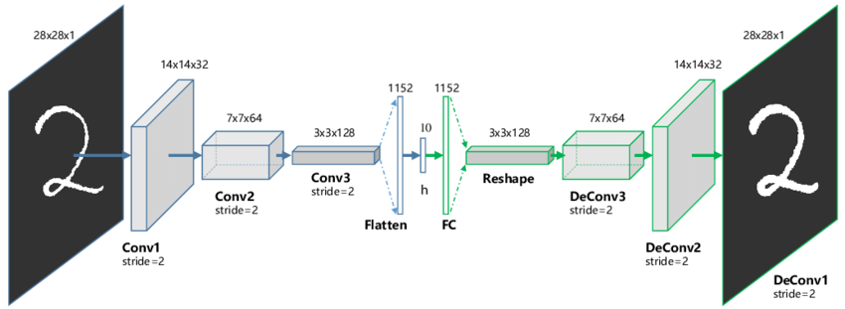

In [0]:
Image('stackedConvAE.png')

- 확률적 생성 네트워크(GSN, Generative Stochastic Network)
데이터를 생성하는 기능을 추가한 잡음제거 오토인코더의 일반화된 모델 (마코프 체인 사용)

- WTA 오토인코더(Winner-Take-All autoencoeder)
훈련하는 도안 코딩층에 있는 모든 뉴런의 활성화를 계산한 후 훈련 배치에서 각 뉴런에 대해 최대 k% 활성화만 보존하고 나머지는 0으로 설정합니다.
이는 자연스럽게 희소 코딩을 만듭니다. 또한 비슷하 WTA 방식을 사용하여 희소한 합성곱 오토인코더를 생성할 수 있습니다.

- 적대적 생성 네트워크(GAN, Generative Adversarial Network)

  - 2014년 NIPS에서 lan Goodfellowr가 발표한 회귀생성 모델.
  
판별자와 생성자라고 부르는 두 번째 네트워크가 만든 가짜 데이터와 실제 데이터를 구분하도록 훈련됩니다. 생성자는 판별자를 속이는 법을 학습하며,
판별자는 생성자의 속임수를 피하는 법을 학습합니다. 이런 경쟁은 매우 현실적인 가짜 데이터와 안정적인 코딩을 생성하도록 만듭니다. 적대적 훈련
은 매우 강력한 아이디어로 많은 관심을 받고 있습니다. 얀 르쿤은 심지어 이를 '지금까지 본 것 중 가장 멋진 아이디어'라고 말했습니다.

출처 - https://www.samsungsds.com/global/ko/support/insights/Generative-adversarial-network-AI-2.html

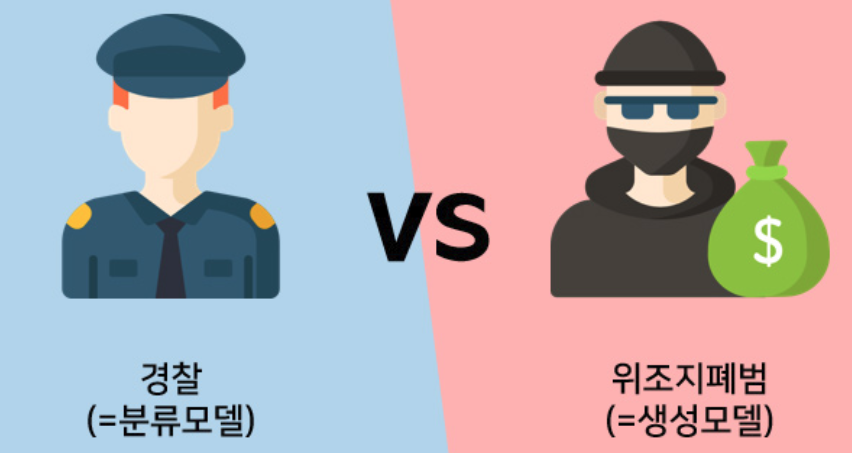

In [0]:
Image('police.PNG')

Ian Goodfellow는 GAN을 경찰과 위조지폐범 사이의 게임에 비유했습니다.
- 위조지폐범은 최대한 진짜 같은 화폐를 만들어(생성) 경찰을 속이기 위해 노력하고, 경찰은 진짜 화폐와 가짜 화폐를 완벽히 판별(분류)하여 위조지폐범을 검거하는 것을 목표로 합니다. 
- 이러한 경쟁적인 학습이 지속되다 보면 어느 순간 위조지폐범은 진짜와 다를 바 없는 위조지폐를 만들 수 있게 되고 경찰이 위조지폐를 구별할 수 있는 확률도 가장 헷갈리는 50%로 수렴하게 되어 경찰은 위조지폐와 실제 화폐를 구분할 수 없는 상태에 이르게 됩니다.

## 확률

GAN에서 다루고자 하는 모든 데이터는 확률분포를 가지고 있는 랜덤변수(Random Variable)이므로 확률분포의 개념을 알아야 한다. 
가령 2차 방정식에서 미지 수 X를 변수라 부르고, 이를 대입해 방정식을 풀면 미지수 X는 특정한 수가 됩니다.
그러나, 랜덤변수는 측정할 때마다 다른 값이 나옵니다. 하지만, 특정한 확률분포를 따르는 숫자를 생성하므로, 
랜덤변수에 대한 확률분포를 안다는 이야기는 랜덤변수 즉 데이터에 대한 전부를 이해하고 있다는 것과 같습니다. 

예를 들어, 확률분포를 알면 그 데이터의 예측 기댓값, 데이터의 분산을 즉각 알아낼 수 있어 데이터의 통계적 특성을 바로 분석할 수 있으며, 주어진 확률분포를 따르도록 데이터를 임의 생성하면 그 데이터는 확률분포를 구할 때 사용한 원 데이터와 유사한 값을 가집니다. 즉, GAN과 같은 비지도학습이 가능한 머신러닝 알고리즘으로 데이터에 대한 확률분포를 모델링 할 수 있게 되면, 원 데이터와 확률분포를 정확히 공유하는 무한히 많은 새로운 데이터를 새로 생성할 수 있음을 의미합니다.

- 수학적으로 위조지폐범(생성자 G)는 원 데이터의 확률분포를 알아내려고 노력하며, 학습이 종료된 후에는 원 데이터의 확률분포를 따르는 새로운 데이터를 만들어 내게 됩니다.

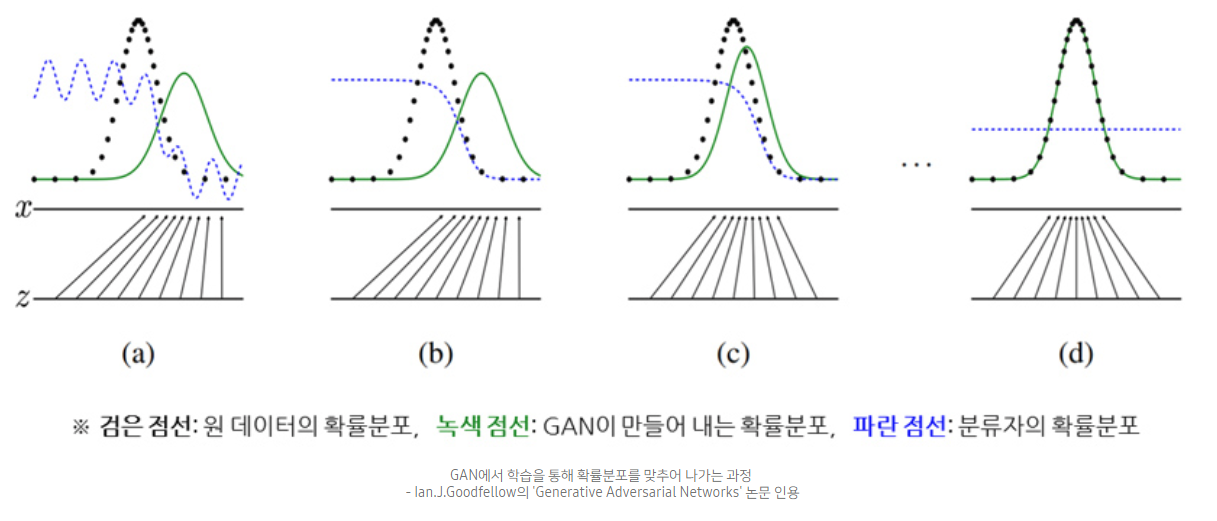

In [0]:
Image('distribution.PNG')

위의 (a)~(d) 그래프에서 원 데이터의 확률분포가 학습이 거듭 진행됨에 따라 GAN이 만들어 내는 확률분포와 거의 동일해 짐을 볼 수 있습니다. 이렇게 되면 파란색 점선인 분류자 D는 더 이상 분류를 해도 의미가 없는 0.5라는 확률 값이 나옵니다. 이것은 동전을 던져서 앞면을 진실, 뒷면을 거짓이라고 했을 때, 진실을 맞출 확률이 0.5가 되는 것처럼 GAN에 의해 만들어진 데이터가 진짜 인지 가짜인지 맞출 확률이 0.5가 되면서 분류자가 의미 없게 되는 겁니다. 결론적으로 생성자 G가 실제 데이터와 거의 유사한 데이터를 만들어 낼 수 있는 상황이 되었음을 의미합니다.

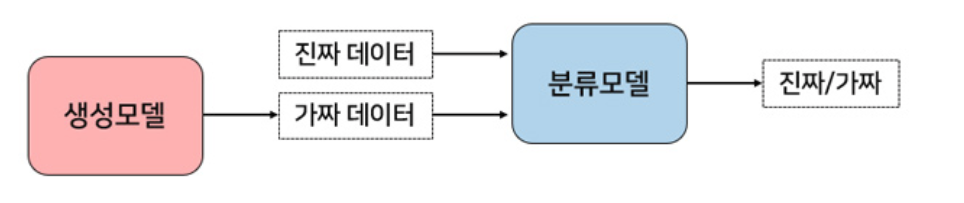

In [0]:
Image('gan.PNG')

분류 모델을 먼저 학습시킨 후, 생성 모델을 학습시키는 과정을 서로 주고받으면서 반복합니다. 

- 분류 모델의 학습은 크게 두 가지 단계로 이루어져 있습니다. 
  - 하나는 진짜 데이터를 입력해서 네트워크가 해당 데이터를 진짜로 분류하도록 학습시키는 과정
  - 두 번째는 첫 번째와 반대로 생성 모델에서 생성한 가짜 데이터를 입력해서 해당 데이터를 가짜로 분류하도록 학습하는 과정 

이 과정을 통해 분류 모델은 진짜 데이터를 진짜로, 가짜 데이터를 가짜로 분류할 수 있게 됩니다. 
분류 모델을 학습시킨 다음에는 학습된 분류 모델을 속이는 방향으로 생성 모델을 학습시켜줘야 합니다. 
생성 모델에서 만들어낸 가짜 데이터를 판별 모델에 입력하고, 가짜 데이터를 진짜라고 분류할 만큼 진짜 데이터와 유사한 데이터를 만들어 내도록 생성 모델을 학습시킵니다. 

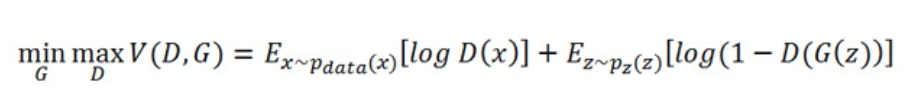

In [0]:
Image('gan_eq.PNG')

- X~Pdata (x)는 실제 데이터에 대한 확률분포에서 샘플링한 데이터를 의미
- Z~Pz(z)는 일반적으로 가우시안분포를 사용하는 임의의 노이즈에서 샘플링한 데이터
- z는 latent vector 차원이 줄어든 채로 데이터를 잘 설명할 수 있는 잠재 공간에서의 벡터
- D(x)는 분류자이고 0과 1 사이의 값을 출력. 데이터가 진짜이면 D(x)는 1, 가짜이면 0의 값을 출력. 
- 두 번째 항에 있는 분류자인 D(G(z))는 G가 만들어낸 데이터인 G(z)가 진짜라고 판단되면 1, 가짜라고 판단되면 0의 값을 출력.

**Minmaxproblem** : V(D,G)에서 분류자 D를 최대화하는 방향으로 학습하고, 생성자 G는 최소화하는 방향으로 학습하는 것.

분류자 D는 데이터 판별을 최대한 잘해야 한다.
생성자 G는 분류자 D를 최대한 속여야 한다. (분류자 입장에선 최대한 진짜처럼.)

 - D의 관점에서 V(D,G)를 최대화 관점에서 우변의 첫 번째 항과 두 번째 항 모두 최대가 되어야 하므로 log(D(x))와 log(1 -D(G(z)) 모두 최대가 되어야 함. 따라서, D(x)는 1이 되어야 하며 이는 실제 데이터를 진짜라고 분류하도록 D를 학습하는 것을 의미. 마찬가지로 1-D(G(z))는 1이 되어 D(G(z))는 따라서 0이어야 하며, 이는 생성자가 만들어낸 가짜 데이터를 가짜라고 분류하도록 분류자를 학습하는 것을 의미합니다. 
 
 => V(D,G)가 최대가 되도록 D를 학습하는 것은 판별자가 진짜 데이터를 진짜로, 가짜 데이터를 가짜로 분류하도록 학습하는 과정입니다.

 - 생성자G가 V(D,G)를 최소화 관점에서 위의 수식의 우변 첫 번째 항에는 G가 포함되어 있지 않으므로 생성자와 연관이 없어 생략이 가능. 두 번째 항을 최소화하기 위해서는 log(1 - D(G(z))가 최소가 되어야 함. log(1 - D(G(z))는 0이 되어야 하고 D(G(z))는 1이 되어야 합니다. 이는 판별자가 진짜로 분류할 만큼 완벽한 가짜 데이터를 생성하도록 생성자를 학습시키는 것을 말함.

출처 - https://tykimos.github.io/2018/10/10/Understanding_Generative_Adversarial_Nets/

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


In [0]:
# 실험을 재현하고 동일한 결과를 얻을 수 있는지 확인하기 위해 seed 를 설정.
np.random.seed(10)

# 우리의 랜덤 노이즈 벡터의 차원을 설정.
random_dim = 100

In [0]:
def load_minst_data():
    # 데이터를 로드.
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    # 데이터를 -1 ~ 1 사이 값으로 normalize.
    x_train = (x_train.astype(np.float32) - 127.5)/127.5

    # x_train 의 shape 를 (60000, 28, 28) 에서 (60000, 784) 로 변형.
    # 따라서 row 당 784 columns 을 가지게 됨.
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [0]:
# Adam Optimizer를 사용.
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

# Generator 만들기
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# Discriminator 만들기
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [0]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # Generator와 Discriminator를 동시에 학습시키고 싶을 때 trainable을 False로 설정.
    discriminator.trainable = False

    # GAN 입력 (노이즈)은 위에서 100 차원으로 설정.
    gan_input = Input(shape=(random_dim,))

    # Generator의 결과는 이미지.
    x = generator(gan_input)

    # Discriminator의 결과는 이미지가 진짜인지 가짜인지에 대한 확률.
    gan_output = discriminator(x)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [0]:
# 생성된 MNIST 이미지를 보여주는 함수
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    print("epoch: ", epoch)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [0]:
def train(epochs=1, batch_size=128):
    # train 데이터와 test 데이터를 가져오기.
    x_train, y_train, x_test, y_test = load_minst_data()

    # train 데이터를 128 사이즈의 batch 로 나눔.
    batch_count = x_train.shape[0] // batch_size

    # GAN 네트워크를 생성.
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # 입력으로 사용할 random 노이즈와 이미지를 가져오기.
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])

            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # MNIST 이미지를 생성.
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 1

            # Discriminator를 학습.
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Generator를 학습.
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------
Instructions for updating:
Use tf.cast instead.


100%|██████████| 468/468 [00:08<00:00, 56.09it/s]


epoch:  1


  1%|▏         | 7/468 [00:00<00:06, 69.17it/s]

--------------- Epoch 2 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.32it/s]

--------------- Epoch 3 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.94it/s]

--------------- Epoch 4 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.63it/s]

--------------- Epoch 5 ---------------


  2%|▏         | 9/468 [00:00<00:05, 84.22it/s]

--------------- Epoch 6 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.22it/s]

--------------- Epoch 7 ---------------


  2%|▏         | 9/468 [00:00<00:05, 84.10it/s]

--------------- Epoch 8 ---------------


  2%|▏         | 9/468 [00:00<00:05, 84.19it/s]

--------------- Epoch 9 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.34it/s]

--------------- Epoch 10 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.45it/s]

--------------- Epoch 11 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.29it/s]

--------------- Epoch 12 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.62it/s]

--------------- Epoch 13 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.94it/s]

--------------- Epoch 14 ---------------


  2%|▏         | 9/468 [00:00<00:05, 84.38it/s]

--------------- Epoch 15 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.22it/s]

--------------- Epoch 16 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.58it/s]

--------------- Epoch 17 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.00it/s]

--------------- Epoch 18 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.97it/s]

--------------- Epoch 19 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.01it/s]

--------------- Epoch 20 ---------------


100%|██████████| 468/468 [00:05<00:00, 81.48it/s]


epoch:  20


  1%|▏         | 7/468 [00:00<00:06, 67.28it/s]

--------------- Epoch 21 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.38it/s]

--------------- Epoch 22 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.70it/s]

--------------- Epoch 23 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.16it/s]

--------------- Epoch 24 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.17it/s]

--------------- Epoch 25 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.29it/s]

--------------- Epoch 26 ---------------


  2%|▏         | 9/468 [00:00<00:05, 84.79it/s]

--------------- Epoch 27 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.35it/s]

--------------- Epoch 28 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.19it/s]

--------------- Epoch 29 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.63it/s]

--------------- Epoch 30 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.73it/s]

--------------- Epoch 31 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.90it/s]

--------------- Epoch 32 ---------------


  2%|▏         | 8/468 [00:00<00:06, 73.71it/s]

--------------- Epoch 33 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.65it/s]

--------------- Epoch 34 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.90it/s]

--------------- Epoch 35 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.52it/s]

--------------- Epoch 36 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.49it/s]

--------------- Epoch 37 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.85it/s]

--------------- Epoch 38 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.10it/s]

--------------- Epoch 39 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.71it/s]

--------------- Epoch 40 ---------------


100%|██████████| 468/468 [00:05<00:00, 80.79it/s]


epoch:  40


  1%|▏         | 7/468 [00:00<00:06, 68.29it/s]

--------------- Epoch 41 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.30it/s]

--------------- Epoch 42 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.66it/s]

--------------- Epoch 43 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.39it/s]

--------------- Epoch 44 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.75it/s]

--------------- Epoch 45 ---------------


  2%|▏         | 9/468 [00:00<00:05, 84.55it/s]

--------------- Epoch 46 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.96it/s]

--------------- Epoch 47 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.74it/s]

--------------- Epoch 48 ---------------


  1%|▏         | 7/468 [00:00<00:06, 66.24it/s]

--------------- Epoch 49 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.82it/s]

--------------- Epoch 50 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.56it/s]

--------------- Epoch 51 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.96it/s]

--------------- Epoch 52 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.58it/s]

--------------- Epoch 53 ---------------


  2%|▏         | 8/468 [00:00<00:05, 76.69it/s]

--------------- Epoch 54 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.14it/s]

--------------- Epoch 55 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.91it/s]

--------------- Epoch 56 ---------------


  2%|▏         | 9/468 [00:00<00:05, 84.22it/s]

--------------- Epoch 57 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.58it/s]

--------------- Epoch 58 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.21it/s]

--------------- Epoch 59 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.72it/s]

--------------- Epoch 60 ---------------


100%|██████████| 468/468 [00:05<00:00, 81.50it/s]


epoch:  60


  1%|▏         | 7/468 [00:00<00:06, 66.72it/s]

--------------- Epoch 61 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.01it/s]

--------------- Epoch 62 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.67it/s]

--------------- Epoch 63 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.65it/s]

--------------- Epoch 64 ---------------


  2%|▏         | 8/468 [00:00<00:05, 77.60it/s]

--------------- Epoch 65 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.02it/s]

--------------- Epoch 66 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.47it/s]

--------------- Epoch 67 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.32it/s]

--------------- Epoch 68 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.27it/s]

--------------- Epoch 69 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.25it/s]

--------------- Epoch 70 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.38it/s]

--------------- Epoch 71 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.84it/s]

--------------- Epoch 72 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.37it/s]

--------------- Epoch 73 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.89it/s]

--------------- Epoch 74 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.99it/s]

--------------- Epoch 75 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.27it/s]

--------------- Epoch 76 ---------------


  2%|▏         | 8/468 [00:00<00:05, 78.39it/s]

--------------- Epoch 77 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.84it/s]

--------------- Epoch 78 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.24it/s]

--------------- Epoch 79 ---------------


  2%|▏         | 8/468 [00:00<00:06, 72.07it/s]

--------------- Epoch 80 ---------------


100%|██████████| 468/468 [00:05<00:00, 80.28it/s]


epoch:  80


  1%|▏         | 7/468 [00:00<00:06, 67.73it/s]

--------------- Epoch 81 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.73it/s]

--------------- Epoch 82 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.92it/s]

--------------- Epoch 83 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.78it/s]

--------------- Epoch 84 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.87it/s]

--------------- Epoch 85 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.61it/s]

--------------- Epoch 86 ---------------


  2%|▏         | 9/468 [00:00<00:05, 85.26it/s]

--------------- Epoch 87 ---------------


  2%|▏         | 8/468 [00:00<00:06, 75.06it/s]

--------------- Epoch 88 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.11it/s]

--------------- Epoch 89 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.20it/s]

--------------- Epoch 90 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.26it/s]

--------------- Epoch 91 ---------------


  2%|▏         | 9/468 [00:00<00:05, 83.86it/s]

--------------- Epoch 92 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.88it/s]

--------------- Epoch 93 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.66it/s]

--------------- Epoch 94 ---------------


  2%|▏         | 8/468 [00:00<00:05, 79.25it/s]

--------------- Epoch 95 ---------------


  2%|▏         | 9/468 [00:00<00:05, 81.02it/s]

--------------- Epoch 96 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.68it/s]

--------------- Epoch 97 ---------------


  2%|▏         | 9/468 [00:00<00:05, 80.67it/s]

--------------- Epoch 98 ---------------


  2%|▏         | 8/468 [00:00<00:06, 76.50it/s]

--------------- Epoch 99 ---------------


  2%|▏         | 9/468 [00:00<00:05, 82.22it/s]

--------------- Epoch 100 ---------------


100%|██████████| 468/468 [00:05<00:00, 81.33it/s]


epoch:  100


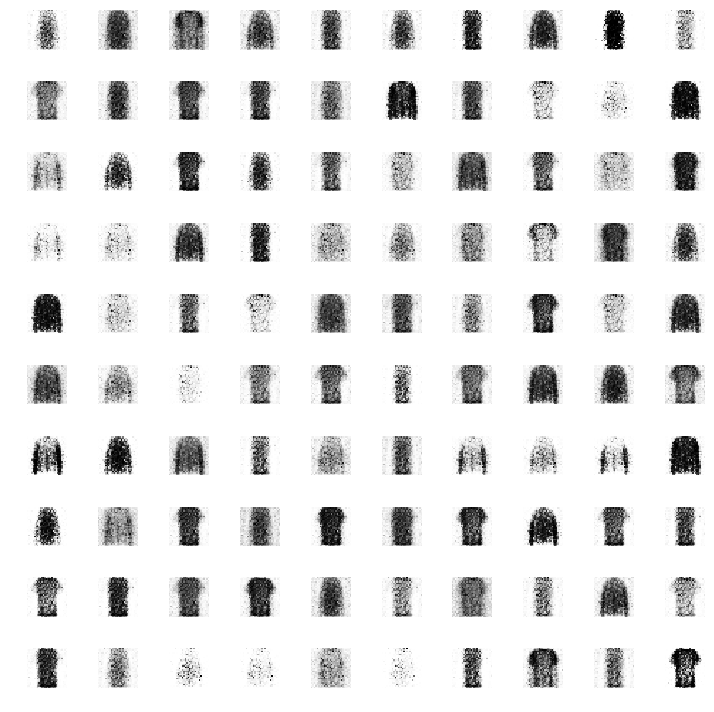

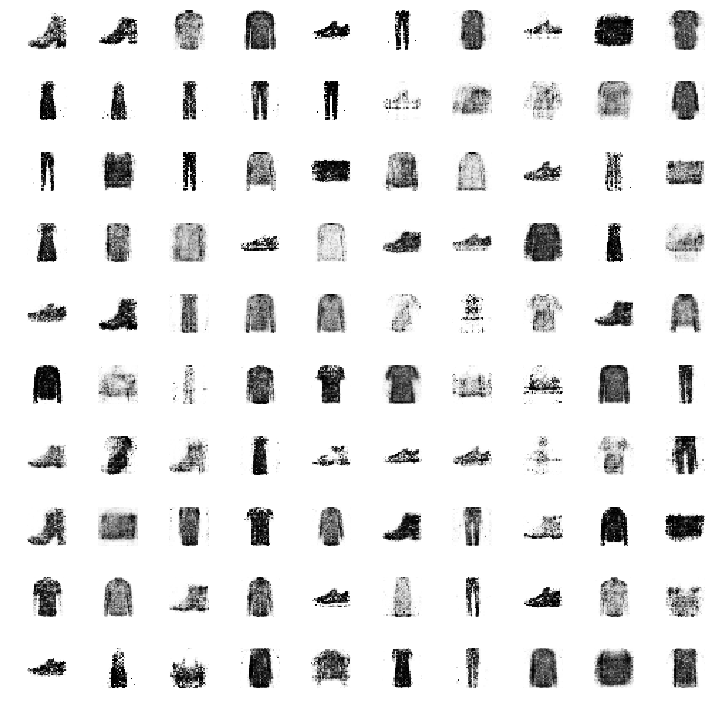

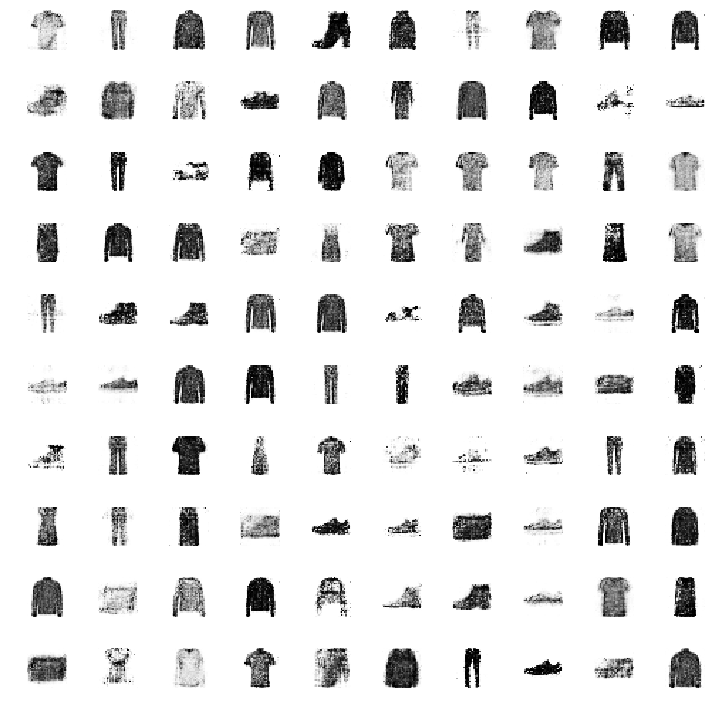

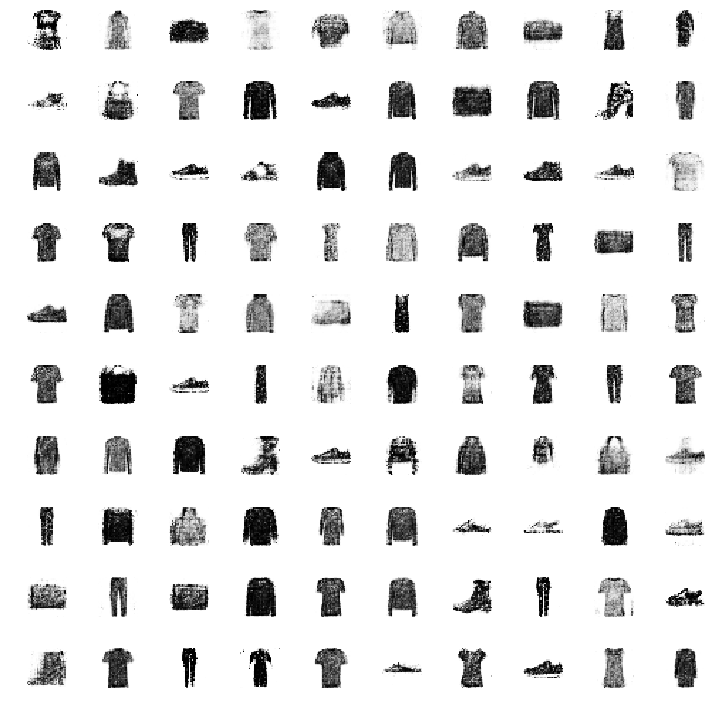

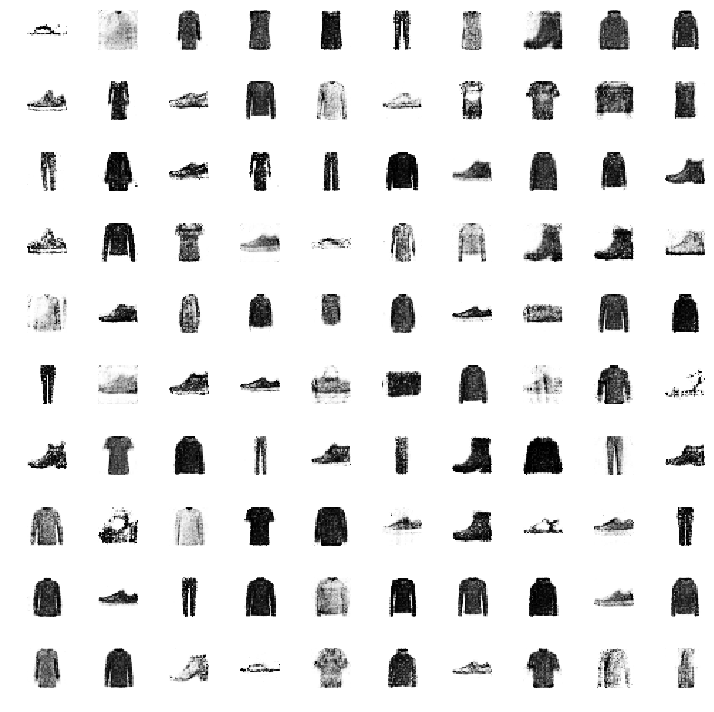

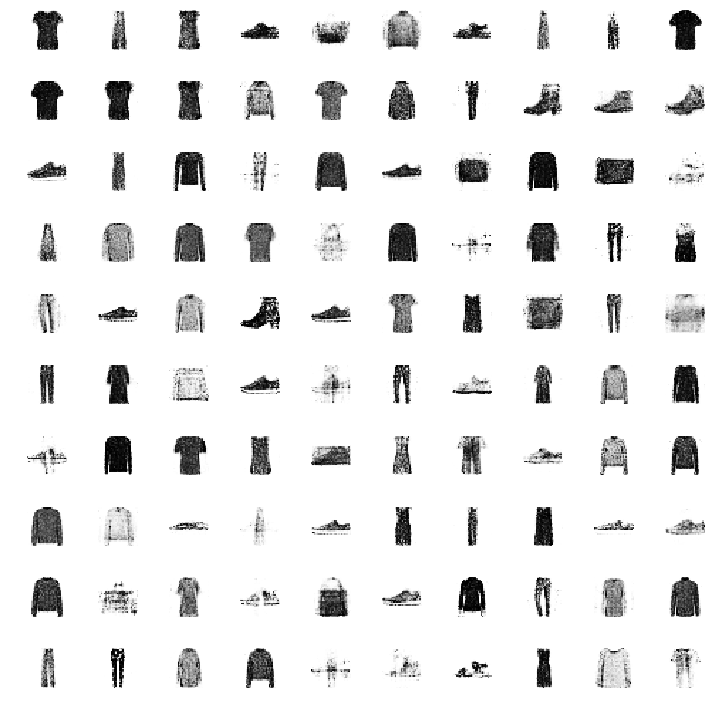

In [0]:
train(100, 128)

# 연습문제 해답

### 10. 이전 연습문제에서 사용한 이미지 데이터셋 (MNIST나 CIFAR10)에 변이형 오토인코더를 훈련시키고 이미지를 생성해보세요. 또는 관심 있는 레이블되어 있지 않은 데이터셋을 찾아보고 새로운 샘플을 생성할 수 있는지 확인해보세요.


In [0]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [0]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # 코딩 유닛
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [0]:
eps = 1e-10 # NaN을 반환하는 log(0)을 피하기 위한 안전항
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [0]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = len(X_train) // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                          
            X_batch, y_batch = next(shuffle_batch(X_train, y_train, batch_size))
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "훈련 전체 손실:", loss_val, "\t재구성 손실:", reconstruction_loss_val, "\t잠재 손실:", latent_loss_val)  # not shown
        saver.save(sess, "./my_model_variational.ckpt") 
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 훈련 전체 손실: 55285.066 	재구성 손실: 47245.22 	잠재 손실: 8039.849
1 훈련 전체 손실: 43523.305 	재구성 손실: 39118.625 	잠재 손실: 4404.681
2 훈련 전체 손실: 45720.316 	재구성 손실: 41197.598 	잠재 손실: 4522.7173
3 훈련 전체 손실: 38479.887 	재구성 손실: 36276.61 	잠재 손실: 2203.2776
4 훈련 전체 손실: 36968.895 	재구성 손실: 35021.273 	잠재 손실: 1947.6211
5 훈련 전체 손실: 39625.383 	재구성 손실: 37663.39 	잠재 손실: 1961.9904
6 훈련 전체 손실: 40833.824 	재구성 손실: 37471.934 	잠재 손실: 3361.8914
7 훈련 전체 손실: 37958.734 	재구성 손실: 35936.633 	잠재 손실: 2022.1023
8 훈련 전체 손실: 36066.004 	재구성 손실: 34106.516 	잠재 손실: 1959.4895
9 훈련 전체 손실: 37961.965 	재구성 손실: 35910.14 	잠재 손실: 2051.823
10 훈련 전체 손실: 38499.035 	재구성 손실: 36510.61 	잠재 손실: 1988.4252
11 훈련 전체 손실: 36274.22 	재구성 손실: 34300.008 	잠재 손실: 1974.2114
12 훈련 전체 손실: 37572.15 	재구성 손실: 35256.242 	잠재 손실: 2315.9077
13 훈련 전체 손실: 43412.957 	재구성 손실: 38159.348 	잠재 손실: 5253.609
14 훈련 전체 손실: 40295.625 	재구성 손실: 37452.484 	잠재 손실: 2843.1392
15 훈련 전체 손실: 36653.562 	재구성 손실: 34720.555 	잠재 손실: 1933.009
16 훈련 전체 손실: 36083.215 	재구성 손실: 34038.56 	잠재 손실: 2044.658
17 훈

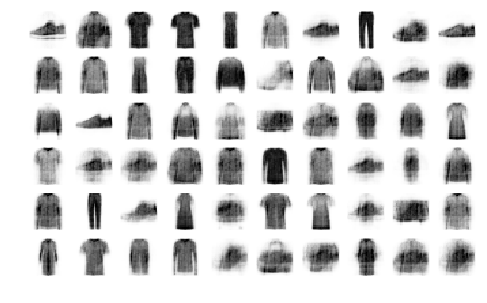

In [0]:
plt.figure(figsize=(8,50)) 
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

1. 오토인코더를 활용할 수 있는 주요 작업은 무엇인가요?

 오토인코더를 활용할 수 있는 주요 작업은 다음과 같습니다.
• 특성 추출 • 비지도 사전훈련
• 차원 축소
• 생성 모델 • 이상치 탐지


2. 레이블 되지 않은 훈련 데이터는 많지만, 레이블된 데이터는 수천 개 정도만 가지고 있을 때 분류기를 훈련시키려 합니다. 오토인코더가 어떻게 도움이 될 수 있을까요? 어떻게 작업하면 될까요?

 레이블 되지 않은 훈련 데이터는 많지만, 레이블된 데이터는 수천 개 정도만 가지고 있을 때 분류기를 훈련시키려면 전체 데이터셋 (레이블된 것 + 레이블되지 않은 것)에 먼저 심층 오토인코더를 훈련시킨 다음 하위층 절반(즉, 코딩층과 그 하위층들)을 재사용합니다. 그리고 레이블된 데이터를 사용해 분류기를 훈련시킵니다. 레이블된 데이터가 조금밖에 없다면 분류기를 훈련시킬 때 재사용된 층을 동결하는 것이 좋습니다.
 

3. 오토인코더가 완벽하게 입력을 재구성했다면, 이것이 반드시 좋은 오토인코더인가요? 오토인코더의 성능을 어떻게 평가할 수 있나요?

 어떤 오토인코더가 입력을 완벽하게 재구성한다는 사실이 반드시 좋은 오토인코더임을 의미하는 것은 아닙니다. 아마도 입력을 코딩층과 출력으로 복사하는 것을 배운 과대완전 오토인코더일지 모릅니다. 사실 코딩층의 뉴런이 한 개여도 매우 깊은 오토인코더는 모든 훈련 샘플을 다른 코딩으로 매핑하는 것이 가능합니다(예를 들어 첫 번째 샘플은 0.001에 두 번째 샘플은 0.002에 세 번째 샘플은 0.003에 매핑되는 식입니다). 그리고 각 코딩에 대한 정확한 훈련 샘플을 재구성하는 것을 외워서 학습할 수 있습니다. 데이터에 있는 어떤 유용한 패턴을 실제 학습하지 않고 입력을 완벽히 재구성합니다. 실전에서 이런 매핑은 거의 일어나지 않지만 완벽하게 재구성되었다는 것이 오토인코더가 유용한 어떤 것을 학습했다고 보장하지 않는다는 사실을 말해줍니다. 하지만 재구성이 매우 나쁘다면 좋지 못한 오토인코더임이 거의 틀림없습니다. 오토인코더의 성능을 재기 위한 한 가지 방법은 재구성 소실을 계산하는 것입니다(예를 들어 출력에서 입력을 뺀 값의 평균 제곱인 MSE를 계산합니다). 여기에서도 높은 재구성 손실은 오토인코더가 나쁘다는 것을 알려주는 좋은 신호입니다. 하지만 재구성 손실이 낮다고 해서 좋은 오토인코더임을 보장할 수는 없습니다. 사용하는 방식에 맞추어 오토인코더를 평가해야 합니다. 예를 들어 분류기의 비지도 사전 훈련을 위해 사용한다면 분류기의 성능도 반드시 평가해야 합니다.


4. 과소완전과 과대완전 오토인코더가 무엇인가요? 지나치게 과소완전인 오토인코더의 주요한 위험은 무엇인가요? 과대완전 오토인코더의 주요한 위험은 무엇인가요?

 과소완전 오토인코더는 코딩층이 입력층과 출력층보다 작은 경우입니다. 만약 코딩층이 더 크다면 과대완전 오토인코더입니다. 아주 심한 과소완전 오토인코더는 입력을 재구성하는데 실패할 가능성이 큽니다. 과대완전 오토인코더의 주된 문제는 유용한 특성을 학습하지 못하고 입력을 출력으로 그냥 복사하는 것입니다.
 

5. 적층 오토인코더에서 가중치를 어떻게 묶나요? 이렇게 하는 이유는 무엇인가요?

 인코더 층의 가중치를 그에 상응하는 디코더 층과 묶으려면 인코더 가중치의 전치를 디코더의 가중치로 사용하면 됩니다. 이렇게 하면 모델의 파라미터 개수가 반으로 줄고, 종종 적은 훈련 데이터로도 수렴이 빨라집니다. 또한 훈련 세트에 과대적합될 위험을 감소시킵니다.

6. 적층 오토인코더의 하위층에서 학습한 특성을 시각화하기 위해 사용하는 일반적인 기법은 무엇인가요? 상위층에 대해서는 어떻게 할 수 있나요?

 스택 오토인코더의 하위층이 학습한 특성을 시각화하기 위한 일반적인 방법은 각 뉴런의 가중치를 입력 이미지의 크기로 바꾸어 그려보는 것입니다(예를 들어 MNIST에서는 [784] 크기의 가중치 벡터를 [28, 28]로 바꿉니다). 상위층에서 학습한 특성을 시각화하기 위한 한 가지 방법은 각 뉴런을 가장 활성화시키는 훈련 샘플을 그려보는 것입니다.


7. 생성 모델이 무엇인가요? 생성 오토인코더의 종류를 나열해보세요.

 생성 모델은 훈련 샘플과 닮은 출력을 랜덤하게 생성할 수 있는 모델입니다. 예를 들어 MNIST 데이터셋에 잘 훈련된 생성 모델은 실제와 같은 임의의 숫자 이미지를 생성할 수 있습니다. 출력 분포는 일반적으로 훈련 데이터와 비슷합니다. 예들 들어 MNIST에는 각 숫자별 이미지가 많기 때문에 이 생성 모델은 각 숫자에 대해 거의 비슷한 개수의 이미지를 출력할 것입니다. 어떤 생성 모델은 특정 종류의 출력만 생성하기 위해 파라미터로 제어할 수 있습니다. 생성 오토인코더의 종류로는 변이형 오토인코더, 제한된 볼츠만 머신(RBM)등이 있습니다.


###8. 이미지 분류기를 사전훈련 시키기 위해 잡음제거 오토인코더를 사용해봅시다.

• MNIST나 조금 더 어려운 걸 원한다면 CIFAR10같은 규모가 큰 이미지셋을 사용합니다. CIFAR10을 선택한다면 훈련을 위해 이미지 배치를 로드하는 코드를 작성해야 합니다. 이 부분을 건너뛰고 싶으면 텐서 플로의 모델 저장소에 있는 도구를 사용할 수 있습니다.


• 데이터셋을 훈련 세트와 테스트 세트로 나누세요. 전체 훈련 세트를 사용해 심층 잡음 제거 오토인코더를 훈련시킵니다.

In [0]:
%autosave 60

import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import batch_norm, dropout
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Autosaving every 60 seconds
Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
import math
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf

# he 표준 초기화
def he_normal_initialisation(n_inputs, n_outputs): 
    stddev = np.power(2 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # 잘린 정규 분포는 가중치들의 크기를 제한하고, 훈련 속도를 높혀줍니다.
    return tf.truncated_normal((n_inputs, n_outputs), stddev=stddev)
  
# he 균일 초기화
def he_uniform_initialisation(n_inputs, n_outputs): 
    r = np.power(6 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    return tf.random_uniform((n_inputs, n_outputs), -r, r)
  
# 다음 배치 생성
def create_next_batch_fn(data, sequence_lengths, targets, batch_size): 
    assert len(data) == len(sequence_lengths) and len(data) == len(targets)
    current_batch = 0
    def next_batch():
        nonlocal current_batch
        i = current_batch
        current_batch = (current_batch + batch_size) % len(data)
        return data[i:i+batch_size], sequence_lengths[i:i+batch_size], targets[i:i+batch_size]
    return next_batch

In [0]:
import math

# 입력 공간 크기
input_spatial_size = 28
input_channels = 1
# 배치 크기
batch_size = 150

learning_rate = 0.01
# 입력 크기 = 784
n_input_neurons = input_spatial_size ** 2
n_hidden_neurons_layer1 = 120
n_hidden_neurons_layer2 = 75
n_hidden_neurons_layer3 = n_hidden_neurons_layer1
n_output_neurons = n_input_neurons
# 정규화 변수
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=(None, n_input_neurons), name="input")
noisy_X = X + tf.random_normal(tf.shape(X), mean=0.1, stddev=0.1)
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
from functools import partial
my_dense_layer = partial(tf.layers.dense,
                             activation=tf.nn.elu,
                             kernel_initializer=he_init)

hidden1 = my_dense_layer(noisy_X, n_hidden_neurons_layer1)
hidden2 = my_dense_layer(hidden1, n_hidden_neurons_layer2)
hidden3 = my_dense_layer(hidden2, n_hidden_neurons_layer3)
    # 출력 값은 자연스럽게 0과 1 사이에 있으므로, 시그모이드 활성화 함수는 값을 나누는 데 유용합니다.
outputs = my_dense_layer(hidden3, n_output_neurons, activation=tf.nn.sigmoid)

with tf.name_scope("loss"):
    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X), name="reconstruction_loss")
    loss = reconstruction_loss# + regularisation_loss

with tf.name_scope("training"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

interim_checkpoint_path = "./checkpoints/mnist_autoencoder_model.ckpt"
early_stopping_checkpoint_path = "./checkpoints/mnist_autoencoder_model_early_stopping.ckpt"

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('loss', loss)
summary_op = tf.summary.merge([loss_summary])
file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

epochs = 100
n_batches = int(np.ceil(len(mnist.train.images) // batch_size))

early_stopping_check_frequency = n_batches // 4
early_stopping_check_limit = n_batches * 3

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session = sess
sess.run(init)

best_loss = 1000000000.0
best_loss_step = 0
for epoch in range(epochs):
    print("epoch", epoch)
    for batch_index in range(n_batches):
        step = epoch * n_batches + batch_index
        # TODO: replace this with code that gets a batch from X and y.
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        if batch_index % 10 == 0:
            summary_str = summary_op.eval(session=sess, feed_dict={X: X_batch})
            file_writer.add_summary(summary_str, step)
        t = sess.run(training_op, feed_dict={X: X_batch})
        if batch_index % 10 == 0:
            l = sess.run(loss, feed_dict={X: X_batch})
            print("loss:", l)
        # 조기 종료 체크
        if batch_index % early_stopping_check_frequency == 0:
            l = sess.run(loss, feed_dict={X: X_batch})
            if l < best_loss:
                saver.save(sess, early_stopping_checkpoint_path)
                best_loss = l
                best_loss_step = step
            elif step >= (best_loss_step + early_stopping_check_limit):
                print("Stopping early during epoch", epoch, "with best loss:", best_loss)
                break
    else:
        continue
    break
    save_path = saver.save(sess, interim_checkpoint_path)
saver.restore(sess, early_stopping_checkpoint_path)
save_path = saver.save(sess, "./checkpoints/mnist_autoencoder_model_final.ckpt")

epoch 0
loss: 0.37833923
loss: 0.07920331
loss: 0.06241521
loss: 0.054238968
loss: 0.047944844
loss: 0.040305614
loss: 0.037352886
loss: 0.034206294
loss: 0.03140836
loss: 0.030972116
loss: 0.030230131
loss: 0.025832694
loss: 0.027881471
loss: 0.02587864
loss: 0.024067175
loss: 0.022960775
loss: 0.0223519
loss: 0.021234497
loss: 0.020200126
loss: 0.020670325
loss: 0.020200202
loss: 0.020051215
loss: 0.020805053
loss: 0.018527703
loss: 0.017872233
loss: 0.018130437
loss: 0.01719606
loss: 0.017160462
loss: 0.017434003
loss: 0.0171431
loss: 0.017777655
loss: 0.0167927
loss: 0.01670833
loss: 0.015845127
loss: 0.016901653
loss: 0.015518803
loss: 0.015206556
epoch 1
loss: 0.016985284
loss: 0.015888035
loss: 0.015662426
loss: 0.014735561
loss: 0.014292588
loss: 0.015285356
loss: 0.014782617
loss: 0.014409327
loss: 0.015238346
loss: 0.014086526
loss: 0.014761629
loss: 0.013282807
loss: 0.013542069
loss: 0.013397572
loss: 0.013462113
loss: 0.013849601
loss: 0.014598147
loss: 0.0128062125
loss: 

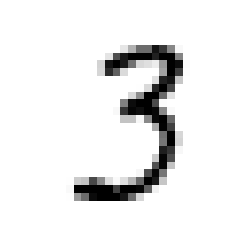

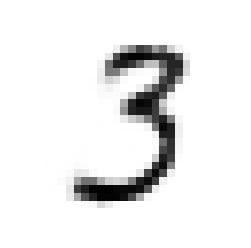

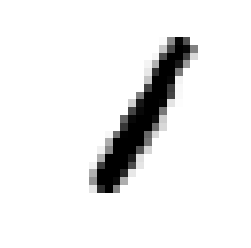

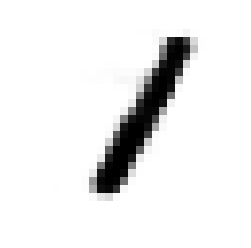

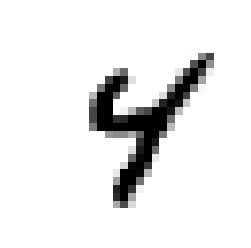

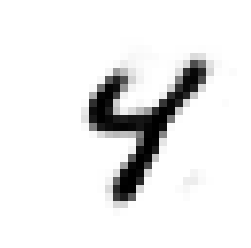

In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# 이미지 표시 함수
def show_image(image):
    plt.imshow(image, cmap = matplotlib.cm.binary,
        interpolation="nearest")
    plt.axis("off")
    plt.show()
    
visualisation_batch = mnist.train.images[:3]
o = sess.run([outputs], feed_dict={X: visualisation_batch})
o = np.array(o).reshape((-1, n_input_neurons))

image_shape = (input_spatial_size, input_spatial_size)
for input_data, output_data in zip(visualisation_batch, o):
    input_image = input_data.reshape(image_shape)
    show_image(input_image)
    output_image = output_data.reshape(image_shape)
    show_image(output_image)

• 이미지가 잘 재구성되는지 확인하고 저수준 특성을 시각화해보세요.

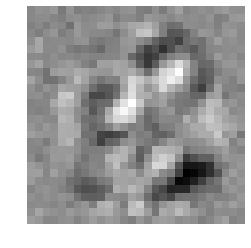

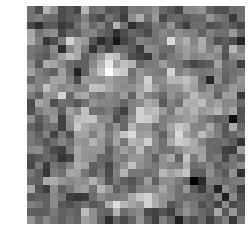

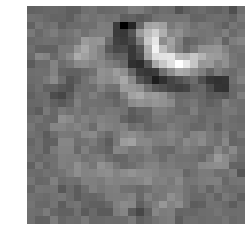

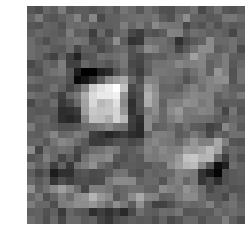

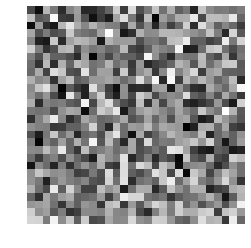

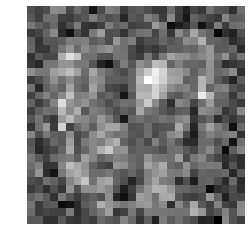

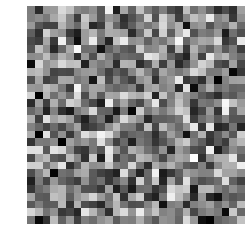

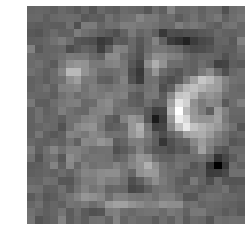

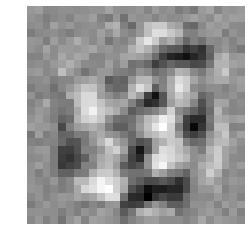

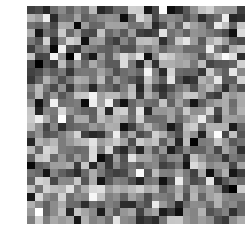

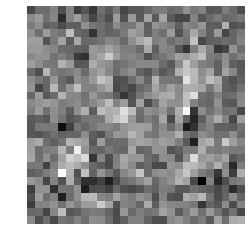

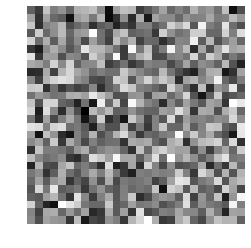

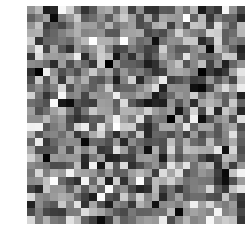

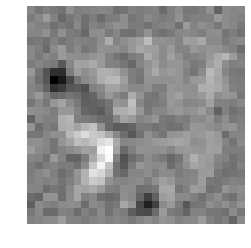

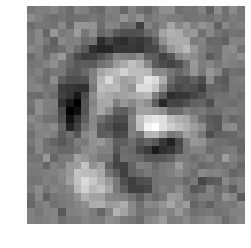

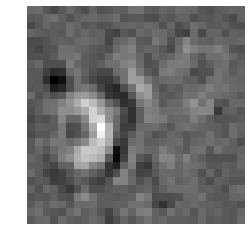

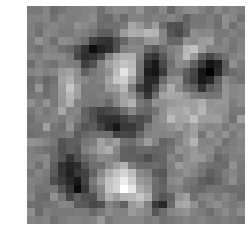

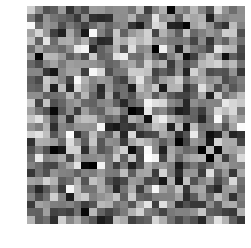

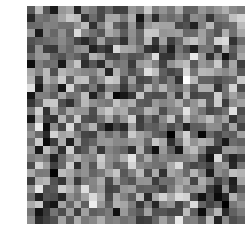

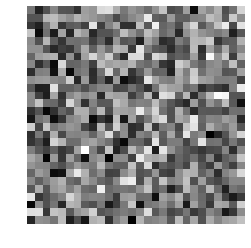

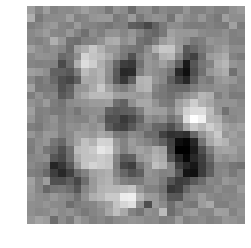

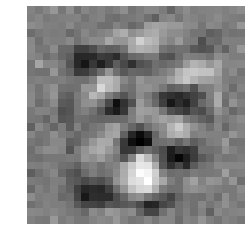

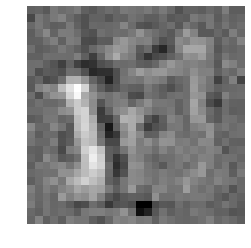

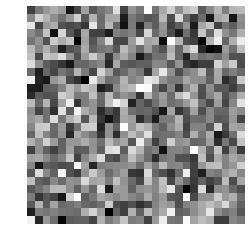

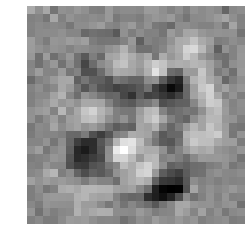

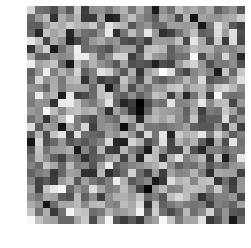

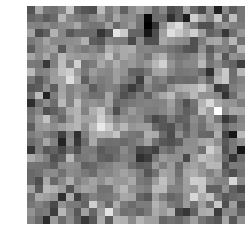

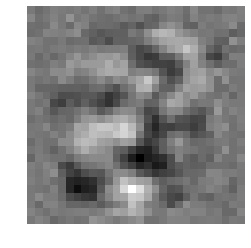

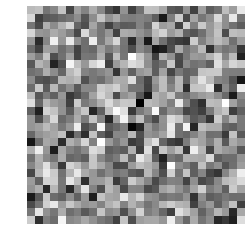

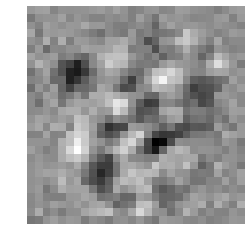

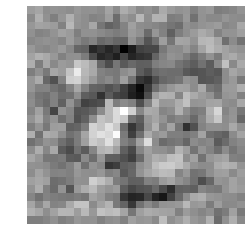

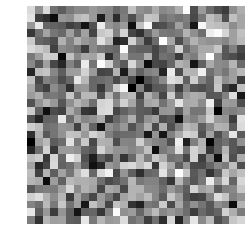

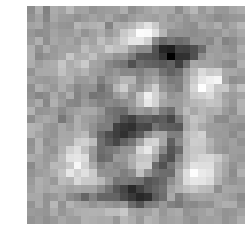

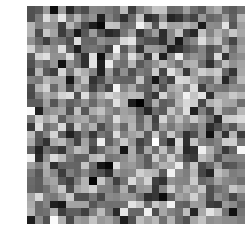

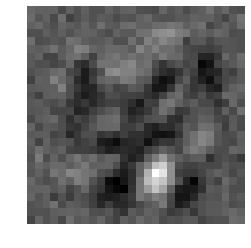

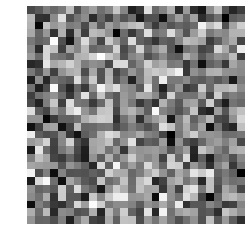

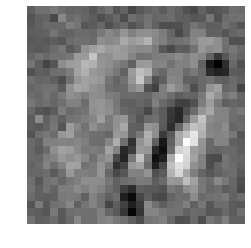

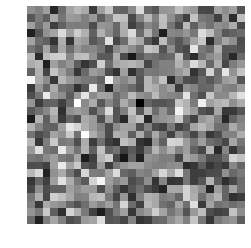

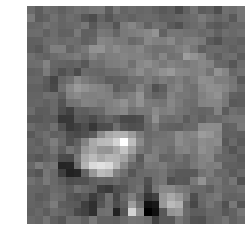

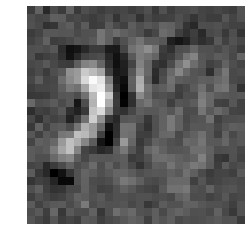

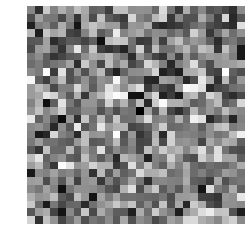

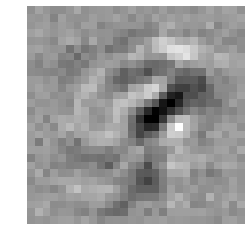

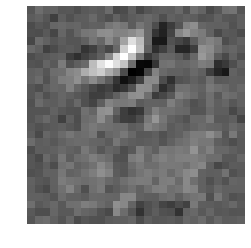

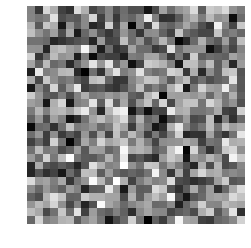

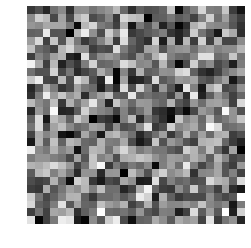

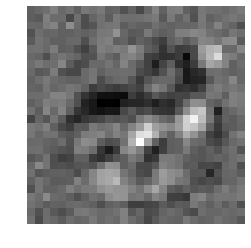

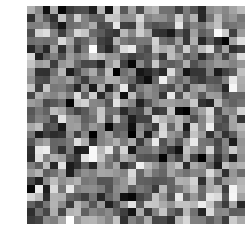

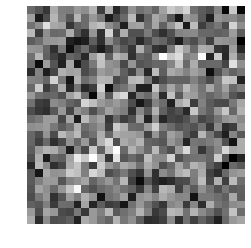

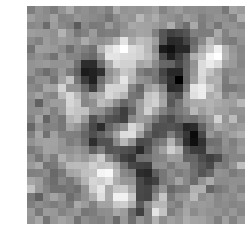

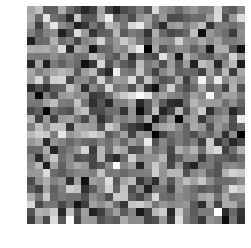

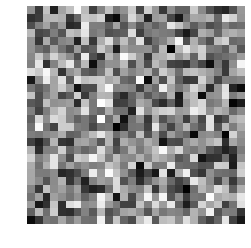

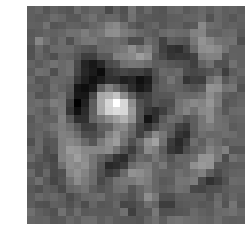

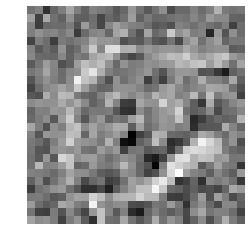

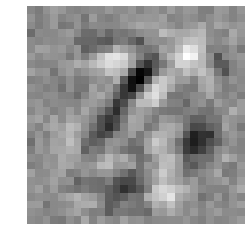

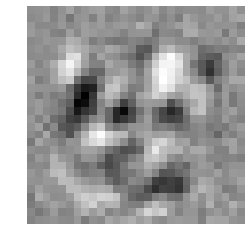

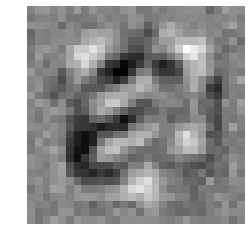

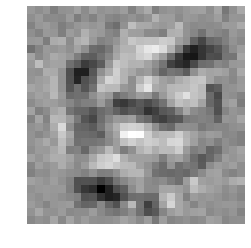

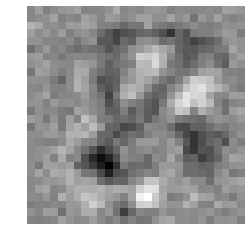

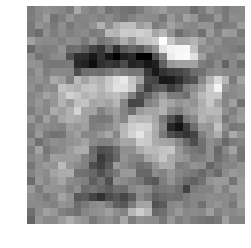

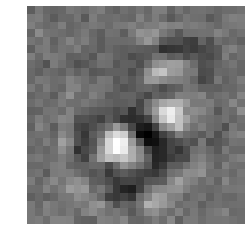

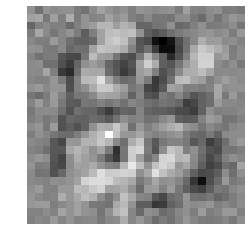

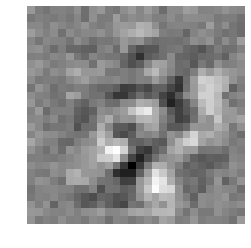

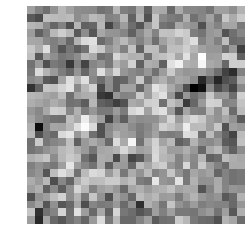

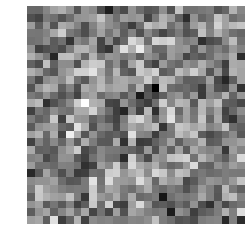

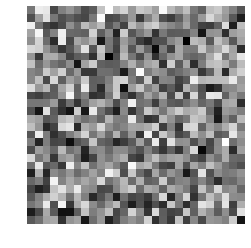

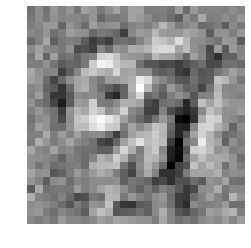

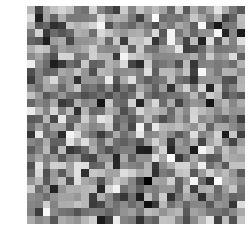

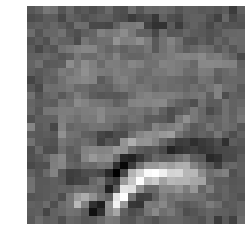

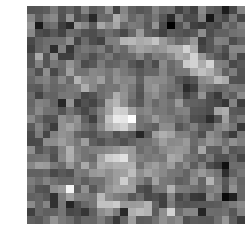

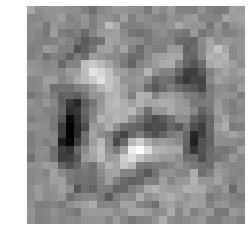

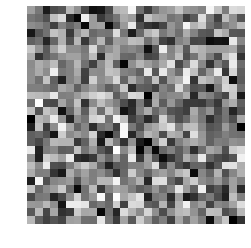

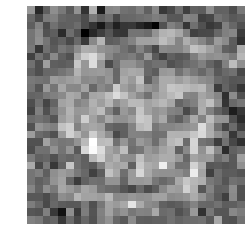

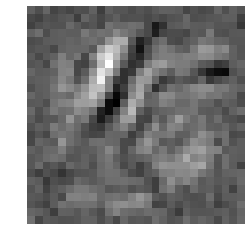

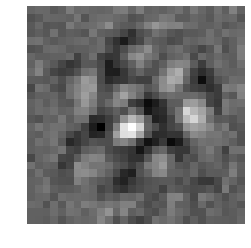

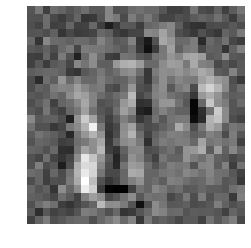

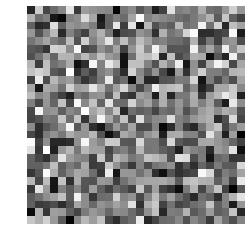

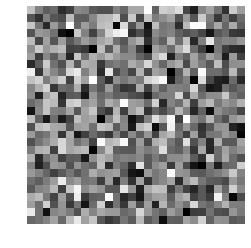

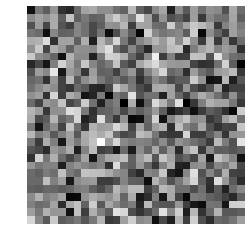

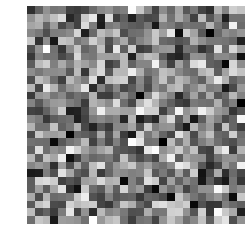

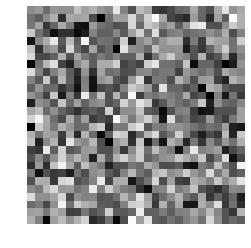

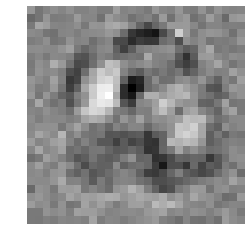

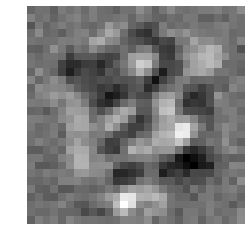

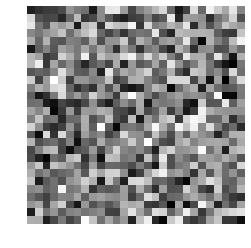

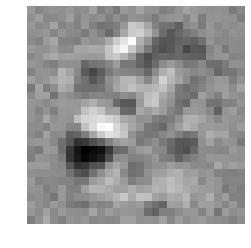

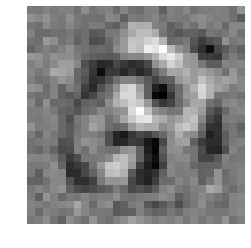

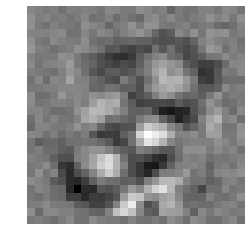

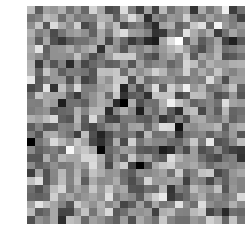

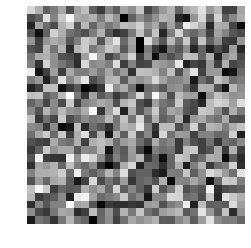

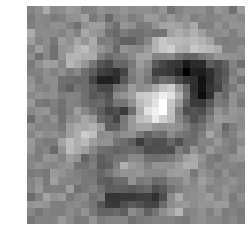

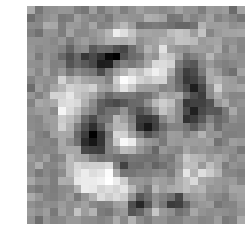

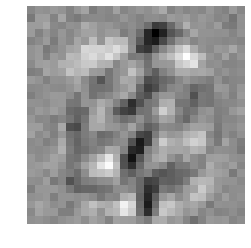

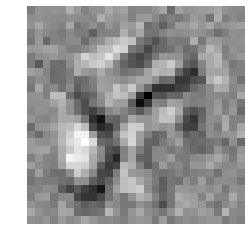

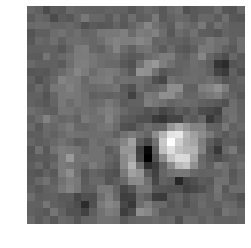

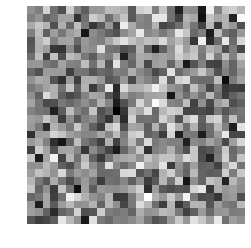

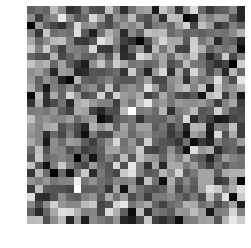

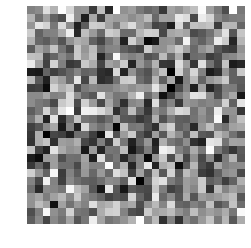

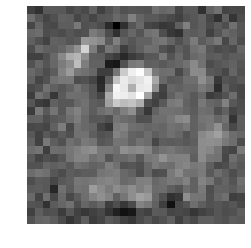

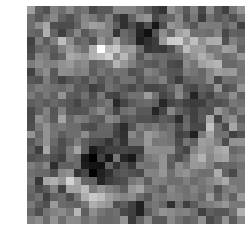

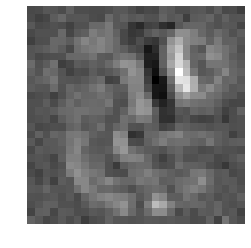

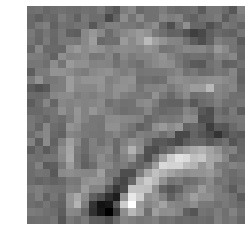

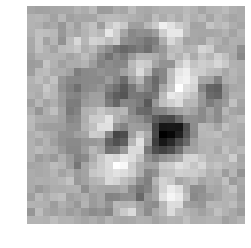

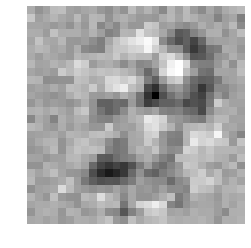

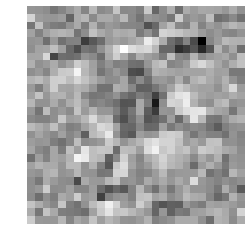

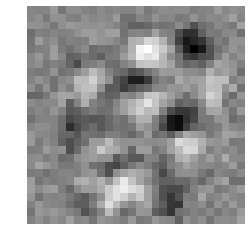

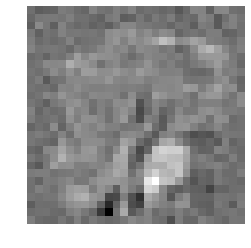

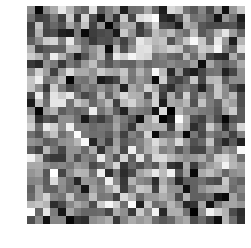

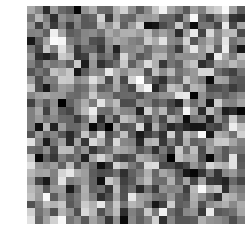

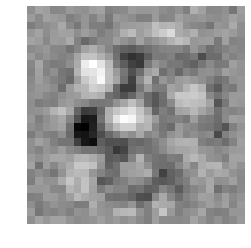

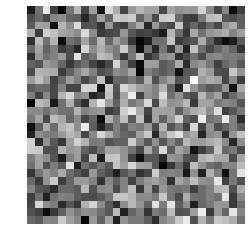

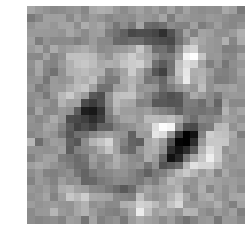

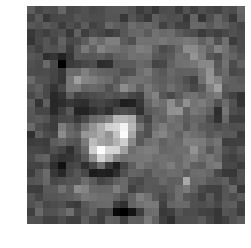

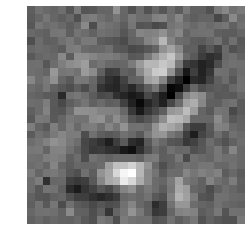

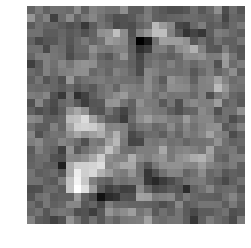

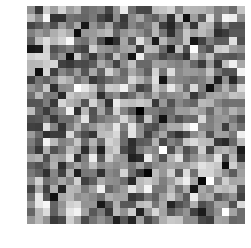

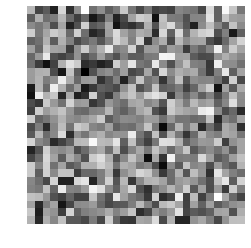

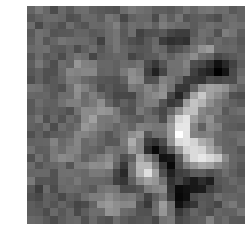

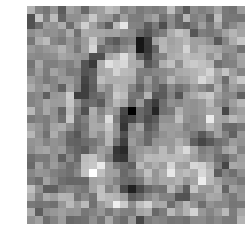

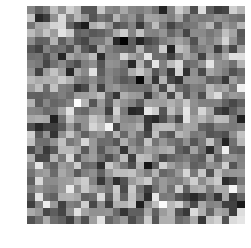

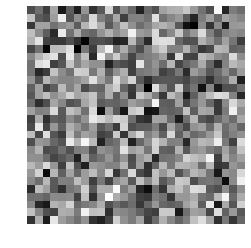

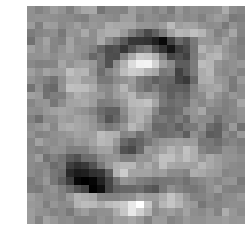

In [0]:
import os

def get_layer_weights(layer):
    return tf.get_default_graph().get_tensor_by_name(os.path.split(layer.name)[0] + '/kernel:0')

with sess.as_default():
    # Go through each low lever neuron and turn its weights into an image.
    hidden1_weights = get_layer_weights(hidden1)
    for neuron_weights in np.transpose(hidden1_weights.eval()):
        show_image(neuron_weights.reshape(image_shape))

흥미롭게도, 어떤 뉴런은 무작위로 가중치를 가지고있는 것으로 보이고 다른 어떤 뉴런들은 숫자 3과 같은 특정 모양이나 규칙있는 숫자를 찾고 있는 것 처럼 보입니다.

• 이 오토인코더의 하위층을 재사용하여 분류를 위한 심층 신경망을 구축합니다. 훈련 세트의 10%만 사용하여 훈련해보세요. 전체 훈련 세트로 훈련시킨 동일한 분류기만큼의 성능을 얻을 수 있나요?

In [0]:
clf_n_hidden_neurons_layer3 = 200

y = tf.placeholder(tf.int32, shape=(None), name="labels")
    
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
from functools import partial
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init)

clf_hidden3 = my_dense_layer(hidden2, clf_n_hidden_neurons_layer3)
logits = my_dense_layer(clf_hidden3, n_output_neurons)

with tf.name_scope("loss"):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    clf_loss = tf.reduce_mean(cross_entropy, name="loss")

with tf.name_scope("training"):
    clf_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    clf_training_op = optimizer.minimize(clf_loss)

with tf.name_scope("eval"):
    k = 1
    correctness = tf.nn.in_top_k(logits, y, k)
    accuracy = tf.reduce_mean(tf.cast(correctness, tf.float32)) * 100.0
    
clf_init = tf.global_variables_initializer()

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

epochs = 6
n_batches = int(np.ceil(len(mnist.train.images) // batch_size))

# 조기 종료 체크 주기
early_stopping_check_frequency = n_batches // 4
# 조기 종료 체크 제한
early_stopping_check_limit = n_batches * 3

saver = tf.train.Saver()
early_stopping_checkpoint_path = "./checkpoints/mnist_model_early_stopping.ckpt"

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(clf_init)

def create_next_batch_fn(images, labels, batch_size):
    assert len(images) == len(labels)
    current_batch = 0
    def next_batch():
        nonlocal current_batch
        i = current_batch
        current_batch = (current_batch + batch_size) % len(images)
        return images[i:i+batch_size], labels[i:i+batch_size]
    return next_batch

training_size = int(len(mnist.train.images) / 10)
print("training dataset size", training_size)
create_next_batch = create_next_batch_fn(
    mnist.train.images[:training_size],
    mnist.train.labels[:training_size],
    batch_size)


best_validation_acc = 0.0
best_validation_step = 0
for epoch in range(epochs):
    print("epoch", epoch)
    for batch_index in range(n_batches):
        step = epoch * n_batches + batch_index
        X_batch, y_batch = create_next_batch()
        t, l, ta = sess.run([clf_training_op, clf_loss, accuracy], feed_dict={X: X_batch, y: y_batch})
        if batch_index % 10 == 0:
            print("loss:", l, "training accuracy:", ta)
        # 조기 종료 체크
        if batch_index % early_stopping_check_frequency == 0:
            validation_acc = sess.run(accuracy, feed_dict={X: mnist.validation.images, y: mnist.validation.labels})
            print("validation accuracy", validation_acc)
            if validation_acc > best_validation_acc:
                saver.save(sess, early_stopping_checkpoint_path)
                best_validation_acc = validation_acc
                best_validation_step = step
            elif step >= (best_validation_step + early_stopping_check_limit):
                print("Stopping early during epoch", epoch)
                break
    else:
        continue
    break
saver.restore(sess, early_stopping_checkpoint_path)
test_acc = sess.run(accuracy, feed_dict={X: mnist.test.images, y: mnist.test.labels})
print(">>>>>>>>>> test dataset accuracy:", test_acc)

training dataset size 5500
epoch 0
loss: 7.1888614 training accuracy: 0.0
validation accuracy 6.46
loss: 4.220206 training accuracy: 34.0
loss: 1.5230052 training accuracy: 52.0
loss: 0.94349885 training accuracy: 74.0
loss: 0.62123734 training accuracy: 74.666664
loss: 0.56518066 training accuracy: 78.0
loss: 0.3670417 training accuracy: 91.333336
loss: 0.32205713 training accuracy: 88.666664
loss: 0.43454874 training accuracy: 82.666664
loss: 0.40520793 training accuracy: 88.666664
validation accuracy 89.560005
loss: 0.3876314 training accuracy: 88.0
loss: 0.29734057 training accuracy: 91.333336
loss: 0.3815071 training accuracy: 86.0
loss: 0.31802627 training accuracy: 87.333336
loss: 0.38644174 training accuracy: 88.666664
loss: 0.24193156 training accuracy: 92.0
loss: 0.29746792 training accuracy: 90.0
loss: 0.1686385 training accuracy: 94.666664
loss: 0.17701945 training accuracy: 92.666664
validation accuracy 92.34
loss: 0.23308179 training accuracy: 90.0
loss: 0.48174524 traini

10%의 훈련 데이터를 사용한 오토인코더는 것은 스크래치에서 전체 데이터셋으로 훈련된 모델(96.47%의 테스트 정확도)보다 2.21% 낮은 94.26%의 테스트 데이터 정확도를 냈습니다. 이는 훈련 데이터 세트가 비교 모델의 훈련 설정 크기의 10%라는 점을 감안할 때 너무 나쁘지 않습니다.

###9. 2008년에 러슬랜 살라쿠티노프(Ruslan Salakhutdinoy)와 제프리 힌튼이 소개한 시맨틱 해싱(Semantic hashing)은 효율적인 정보 검색(information retrieval)을 위한 기법입니다. 한 문서(예를 들면 하나의 이미지)가 보통 신경망으로 구성된 시스템을 통과하면 매우 낮은 차원의 이진 벡터 (예를 들면 30비트)가 출력됩니다. 비슷한 두 개의 문서는 동일하거나 거의 비슷 하 해시를 가질 것입니다. 해시를 사용하여 문서를 인덱싱하면 수십억 개의 문서가 있더라도 특정 문서와 비슷한 여러 문서를 거의 동시에 검색할 수 있습니다. 즉, 문서의 해시를 계산하고 같은(또는 한 개나 두 개의 비트가 다른) 해시를 가진 모든 문서를 찾기만 하면 됩니다. 적층 오토인코더를 조금 변형하여 시맨틱 해싱을 구현해보겠습니다.

• 코딩층 아래에 두 개의 은닉층을 가지는 적층 오토인코더를 생성하고 이전 연습문제에서 사용한 이미지 데이터셋으로 훈련시킵니다. 코딩층은 30개의 뉴런을 가지고 0과 1 사이의 값을 출력하기 위해 로지스틱 활성화 함수를 사용해야 합니다. 훈련이 끝난 뒤 이미지의 해시를 만들기 위해서는 오토인코더를 통과시키고 출력된 코딩층의 각 값을 가까운 정수(0 또는 1)로 반올림하면 됩니다.

• 살라쿠티노프와 힌튼이 제안한 한 가지 멋진 기교는 (평균이 0인) 가우시안 잡음을 훈련하는 동안에만 코딩층의 입력에 추가하는 것입니다. 신호 대비 잡음 signal-to-noise 비 율을 높게 유지하기 위해 오토인코더가 코딩층에 큰 값을 주입하도록 학습될 것입니다. (잡음을 무시하기 위해). 결과적으로 이는 코딩층의 로지스틱 함수가 0 또는 1로 수렴 하게 될 가능성이 높다는 뜻입니다. 결국 코딩을 0 또는 1로 반올림해도 결과를 너무 왜곡하지 않게 되고, 해시의 신뢰도를 향상시킬 것입니다.

In [0]:
import math

input_spatial_size = 28
input_channels = 1
batch_size = 80

learning_rate = 0.005
n_inputs = 28 * 28
n_hidden1 = 100
n_hidden2 = 70  
n_hidden3 = 30 # 코딩 유닛
n_hidden4 = n_hidden2 
n_hidden5 = n_hidden1 
n_outputs = n_inputs
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="input")
noisy_X = X + tf.random_normal(tf.shape(X), mean=0.1, stddev=0.1)
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
from functools import partial
my_dense_layer = partial(tf.layers.dense,
                             activation=tf.nn.elu,
                             kernel_initializer=he_init)

hidden1 = my_dense_layer(noisy_X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
# 코딩 입력에 노이즈를 추가하여 모델에서 큰 값을 입력하여 노이즈를 "제거"합니다.
coding_input = hidden2 + tf.random_normal(tf.shape(hidden2), mean=0.0, stddev=0.3)
codings = my_dense_layer(coding_input, n_hidden3, activation=tf.nn.sigmoid, kernel_initializer=tf.contrib.layers.xavier_initializer())
hidden4 = my_dense_layer(codings, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
# 출력 값은 자연스럽게 0과 1 사이에 있으므로, 시그모이드 활성화 함수는 값을 나누는 데 유용합니다.
outputs = my_dense_layer(hidden5, n_outputs, activation=tf.nn.sigmoid, kernel_initializer=None)

with tf.name_scope("loss"):
    reconstruction_loss = tf.reduce_mean(tf.square(outputs - X), name="reconstruction_loss")
    loss = reconstruction_loss# + regularisation_loss

with tf.name_scope("training"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

interim_checkpoint_path = "./checkpoints/mnist_semantic_hashing_model.ckpt"
early_stopping_checkpoint_path = "./checkpoints/mnist_semantic_hashing_model_early_stopping.ckpt"

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('loss', loss)
summary_op = tf.summary.merge([loss_summary])
file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

epochs = 100
n_batches = int(np.ceil(len(mnist.train.images) // batch_size))

# 조기 종료 체크 주기
early_stopping_check_frequency = n_batches // 4
# 조기 종료 체크 제한
early_stopping_check_limit = n_batches * 3

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session = sess
sess.run(init)

best_loss = 1000000000.0
best_loss_step = 0
for epoch in range(epochs):
    print("epoch", epoch)
    for batch_index in range(n_batches):
        step = epoch * n_batches + batch_index
        # TODO: replace this with code that gets a batch from X and y.
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        if batch_index % 10 == 0:
            summary_str = summary_op.eval(session=sess, feed_dict={X: X_batch})
            file_writer.add_summary(summary_str, step)
        t = sess.run([training_op], feed_dict={X: X_batch})
        l = sess.run(loss, feed_dict={X: X_batch})
        if batch_index % 10 == 0: print("loss:", l)
        # 조기 종료 체크
        if batch_index % early_stopping_check_frequency == 0:
            if l < best_loss:
                saver.save(sess, early_stopping_checkpoint_path)
                best_loss = l
                best_loss_step = step
            elif step >= (best_loss_step + early_stopping_check_limit):
                print("Stopping early during epoch", epoch, "with best loss:", best_loss)
                break
    else:
        continue
    break
    save_path = saver.save(sess, interim_checkpoint_path)
saver.restore(sess, early_stopping_checkpoint_path)
print("total training loss:", sess.run(loss, feed_dict={X: mnist.train.images}))
save_path = saver.save(sess, "./checkpoints/mnist_semantic_hashing_model_final.ckpt")

epoch 0
loss: 0.20398761
loss: 0.0708838
loss: 0.07229429
loss: 0.06901253
loss: 0.06409615
loss: 0.0630189
loss: 0.061219312
loss: 0.062343072
loss: 0.059783693
loss: 0.055046517
loss: 0.051431205
loss: 0.050496895
loss: 0.050629124
loss: 0.049471587
loss: 0.046292912
loss: 0.0462023
loss: 0.04678931
loss: 0.04685284
loss: 0.045283422
loss: 0.04664896
loss: 0.041416183
loss: 0.042336438
loss: 0.04272098
loss: 0.038918313
loss: 0.039984394
loss: 0.036915567
loss: 0.03467884
loss: 0.038930684
loss: 0.035953958
loss: 0.033901986
loss: 0.035733573
loss: 0.033974353
loss: 0.0372837
loss: 0.03401359
loss: 0.032581102
loss: 0.032176018
loss: 0.035932537
loss: 0.03326757
loss: 0.03286691
loss: 0.031730413
loss: 0.03215327
loss: 0.02969548
loss: 0.028949726
loss: 0.030335365
loss: 0.030604234
loss: 0.030071177
loss: 0.027319392
loss: 0.03091022
loss: 0.028623749
loss: 0.02990663
loss: 0.02846408
loss: 0.02673378
loss: 0.028284827
loss: 0.02668308
loss: 0.025172098
loss: 0.027223745
loss: 0.026

코딩 레이어의 입력에 노이즈를 추가하면 모델 손실이 증가하지만 이전보다 코딩 값을 0과 1로 더 잘 나누므로 해시가 더 유용해집니다.

In [0]:
# 숫자 재현 함수
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        outputs_val = outputs.eval(feed_dict={X: X_test[:n_test_digits]})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

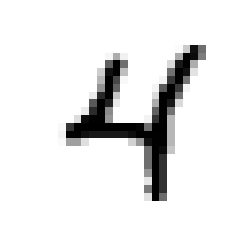

[1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0]


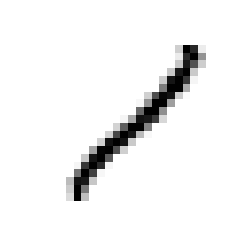

[1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0]


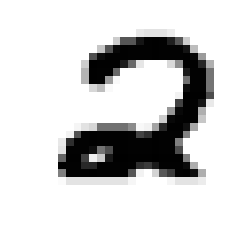

[0 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 1]


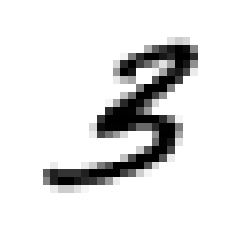

[0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0]


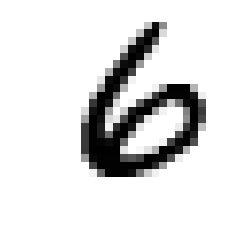

[1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 0]


In [0]:
# 코딩을 비트로 바꾸는 함수
def coding_to_bit_hash(coding):
    return np.array(list(map(lambda a: int(round(a)), coding)))

images = mnist.train.images[:5]
codings_output = sess.run(codings, feed_dict={X: images})
for i in range(len(images)):
    show_image(images[i].reshape(image_shape))
    coding = codings_output[i]
    print(coding_to_bit_hash(coding))

In [0]:
# 비트 해시를 정수로 변환하는 함수
def bit_hash_to_int(bit_hash):
    bit_str = "".join(map(lambda a: str(a), bit_hash))
    return int(bit_str, 2)

In [0]:
codings_output = sess.run(codings, feed_dict={X: mnist.train.images})

# 매칭 사전 생성 함수
def create_matching_dictionary(codings, labels):
    coding_int_to_labels = {}
    for i in range(len(codings)):
        label = labels[i]
        coding_int = bit_hash_to_int(coding_to_bit_hash(codings_output[i]))
        if not coding_int in coding_int_to_labels:
            coding_int_to_labels[coding_int] = []
        coding_int_to_labels[coding_int].append(label)
    return coding_int_to_labels

coding_int_to_labels = create_matching_dictionary(codings_output, mnist.train.labels)

• 전체 이미지의 해시를 계산하고 동일한 해시를 가진 이미지들이 어떤지 확인해보세요. MNIST와 CIFAR10은 레이블되어 있기 때문에 시맨틱 해싱을 위한 오토인코더의 성 능을 측정하는 객관적인 방법은 같은 해시의 이미지가 동일한 클래스인지 확인하는 것 입니다. 이렇게 하기 위한 한 가지 방법은 동일한(또는 매우 비슷한) 해시를 가진 이미지의 묶음에 대한 평균 지니 순도를 계산하는 것입니다 (6장에서 소개했습니다).

In [0]:
for hash_int, labels in coding_int_to_labels.items():
    if len(labels) > 1:
        print(labels)

[1, 1, 1, 1, 1]
[6, 6]
[1, 1]
[8, 8]
[1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1]
[7, 7, 7, 7, 7]
[3, 3]
[1, 1, 1, 1]
[9, 7, 7]
[1, 1]
[1, 1, 1, 1, 1]
[9, 9]
[6, 6]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1]
[4, 4]
[8, 8]
[3, 8, 5]
[0, 0]
[6, 6, 6]
[5, 5, 5]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
[1, 1]
[1, 1, 1, 1]
[1, 1, 1]
[8, 8]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1]
[2, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[4, 4]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3, 3]
[6, 6]
[7, 7, 7, 7, 7, 7]
[0, 0]
[9, 9, 9]
[6, 6, 6]
[7, 7]
[0, 0

In [0]:
# 여러 이미지를 가지고 있는 해시
non_unique_hashes = len(mnist.train.images) - len(coding_int_to_labels)
print("Number of images that share a hash:", non_unique_hashes)
print("Percentage of images that share a hash:", non_unique_hashes / len(mnist.train.images) * 100.0)

# 쓸모없는 해시
n_invalid_hash_sets = 0
for hash_int, labels in coding_int_to_labels.items():
    if len(set(labels)) > 1:
        n_invalid_hash_sets += 1
print("Number of invalid hash sets:", n_invalid_hash_sets)
print("Percentage of invalid hash sets:", n_invalid_hash_sets / non_unique_hashes * 100.0)

Number of images that share a hash: 9990
Percentage of images that share a hash: 18.163636363636364
Number of invalid hash sets: 141
Percentage of invalid hash sets: 1.4114114114114114


더 많은 이미지가 해시를 공유하도록 코드를 변경할 수 있지만 유효하지 않은 해시 설정 비율이 1.4 %로 낮으므로 충분합니다.

• 레이블된 데이터셋으로 할 수 있는 다른 접근 방법은 분류를 위한 합성곱 신경망 (13장 참조)을 훈련시키는 것입니다. 그런 다음 해시를 생성하기 위해 출력층 아래에 있는 층을 사용합니다. 진마 귀(Jinma Guo)와 지앤민 리(Jianmin li)의 2015년 논문을 참고하세요. 이 방법이 더 나은 성능을 내는지 확인해보세요.

행렬을 재구성하는 대신에 CNN 기반 해싱 방법을 제안했습니다. 즉, 완전히 연결된 레이어의 활성화를 임계 값 0으로 이진화하고 이진 결과를 해시 코드로 취하는 방법을 제안했습니다. 이 방법은 CIFAR-10에서 최고의 성능을 달성했으며 MNIST의 최첨단 기술과 비교되었습니다.

해싱 기능과 피쳐 추출 기능의 공동 적응이 중요하다고 제안했습니다.
우리는 CNN만으로 분류 된 데이터로 해싱을 배우는 방법으로 CIFAR-10에서 최상의 성능을 보았습니다 (8 % ~ 16 % 향상).

우리는 CNN이 배운 해싱이 KSH [24]보다 낫다는 것을 보여주었습니다.

우리가 제안한 CNNBH에 관해서는, 각 데이터 세트의 5000 개의 표본 샘플을 5 개의 폴드로 나누어 교차 검증을 실시하여 가장 적합한 모델을 찾은 다음 모든 5000 개의 샘플로 트레이닝했습니다.

훈련을 위해 단지 5000 개의 샘플을 사용해서 우리는 어떤 완전 연결된 레이어의 출력을 이진화하여 주어진 이미지의 바이너리 해시 코드를 얻을 수있는 새로운 방법을 제안했습니다. (우리는 처음에 완전히 연결된 레이어를 선택했다.) CIFAR-10에서 최상의 결과를 얻었습니다.
